# Business Context

Cardio Catch Disease is a company specialized in detecting cardiac diseases at early stages.

- **Business Model:** The price of the diagnosis varies according to the accuracy achieved by the team of specialists, the client pays R$500 for each 5% accuracy above 50%.


- **Actual Scenario:** The current diagnostic accuracy varies between 55% and 65%, due to the complexity of the diagnosis, at a cost of R$1000.


- **Main Goal:** Create a disease diagnosis tool with stable accuracy. 


- **Secundary Goals:** Delivery a report ansewirng the follow questions:
    1. How accurate and precise is the tool?
    2. How much profit Cardio Catch Diseases will make with the new tool?
    3. How reliable are the results given by the new tool?
    

Business Project reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

Data Source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

# 0.0. Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# statistics
from scipy.stats import chi2_contingency, pointbiserialr

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# load images
from IPython.display import Image

# stratified sampling
from sklearn import model_selection as ms

# data preparation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# save objects
import pickle

# feature selection
from boruta import BorutaPy
from sklearn import decomposition

# machine learning models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate

# hyperparameter tuning
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence

# api requests
import requests

# warning
import warnings
warnings.filterwarnings( 'ignore' )

C:\Users\Ganso\anaconda3\envs\cardio-disease-diagnosis\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    # simple cross tabulation
    cm = pd.crosstab(x, y).values
    
    # number of observations
    n = cm.sum()
    
    # number of rows and columns
    r, k = cm.shape
    
    # phi coefficient
    chi2 = chi2_contingency(cm)[0]
    
    # correction of phi coefficient
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    # number of rows and columns correction
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data
- Data source: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [3]:
data_raw = pd.read_csv('../datasets/cardio_train.csv', sep=';')

## 0.3. Split Data into Train and Test

In [4]:
data_train, data_test = ms.train_test_split(data_raw, test_size=0.2, random_state=42)

# 1.0. Data Description

In [5]:
df01 = data_train.copy()

## 1.1. Features Description 

**age:** Age in days

**height:** Height in cm

**weight:** Weight in kg

**gender:** Gender

**ap_hi:** Systolic blood pressure

**ap_lo:** Diastolic blood pressure

**cholesterol:** Cholesterol (1: normal, 2: above normal, 3: well above normal)

**gluc** Glucose (1: normal, 2: above normal, 3: well above normal)

**smoke:** Smoking

**alco:** Alcohol intake

**active:** Physical activity

**cardio:** Presence or absence of cardiovascular disease (Target Variable)

## 1.2. Data Types

In [6]:
df01.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3. Data Dimensions

In [7]:
print(f'Number of rows: {df01.shape[0]}')
print(f'Number of columns: {df01.shape[1]}')

Number of rows: 56000
Number of columns: 13


## 1.4. Check NA

In [8]:
df01.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5. Fillout NA
There is no NA in the dataset

## 1.6. Change Data Type

In [9]:
# convert age to years
df01['age'] = np.round(df01['age']/365, 2)

# convert gender to binary 
df01['gender'] = df01['gender'] - 1

## 1.7. Check Balance Data

In [10]:
df01['cardio'].value_counts(normalize=True)

0    0.500589
1    0.499411
Name: cardio, dtype: float64

 - Dataset with the two categories well balanced with approximately 50% for both classes

## 1.8. Descriptive Analysis

In [11]:
# select numeric attributes
num_attributes = df01[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]

# select categoric attributes (include binary and status attributes)
cat_attributes = df01[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### 1.8.1. Numerical Attributes

In [12]:
# central tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# join dataframes
num_stats = pd.concat([min_, max_, range_, mean, median, skew, kurtosis]).T.reset_index()
num_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']

# display numerical analysis
num_stats

,attributes,min,max,range,mean,median,skew,kurtosis
0,age,29.58,64.97,35.39,53.328568,53.97,-0.305527,-0.823468
1,height,55.00,250.00,195.00,164.348125,165.00,-0.594831,7.616794
2,weight,22.00,200.00,178.00,74.188586,72.00,1.015661,2.630229
3,ap_hi,-140.00,14020.00,14160.00,128.737893,120.00,85.641414,7642.334178
4,ap_lo,0.00,11000.00,11000.00,97.025536,80.00,31.969044,1369.195570


- The lowest height (55 cm) and the highest height (250 cm) seem incorrect;
- Minimum weight (22kg) seems incorrect considering the youngest patient is 29 years old;
- Negative systolic pressure seems incorrect;
- Systolic and diastolic pressures with exobirtant maximum values seem incorrect;

### 1.8.2. Categorical Attributes

In [13]:
cat_attributes.astype('object').describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,56000,56000,56000,56000,56000,56000,56000
unique,2,3,3,2,2,2,2
top,0,1,1,0,0,1,0
freq,36401,41910,47619,51030,52929,45011,28033


- 65.00% of patients are of one gender;
- 91.13% of patients are non-smokers;
- 94.52% of patients do not drink alcohol:;
- 80.38% of patients practice pshysical activity;

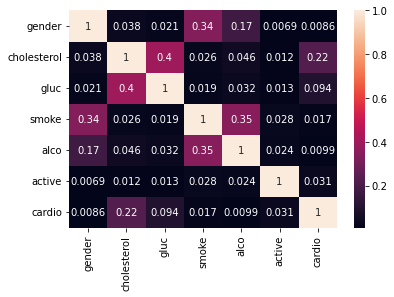

In [14]:
cat_columns = cat_attributes.columns.tolist()

corr_dict = {}

for main_cols in cat_columns:
    corr_list = []
    
    for secundary_cols in cat_columns:
        #cramer v
        cat_corr = cramer_v(cat_attributes[main_cols], cat_attributes[secundary_cols])
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation
    corr_dict[main_cols] = corr_list
    
df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)
sns.heatmap(df_corr, annot=True);

# 2.0. Feature Engineering

In [15]:
df02 = df01.copy()

## 2.1. Mental Map of Hypothesis

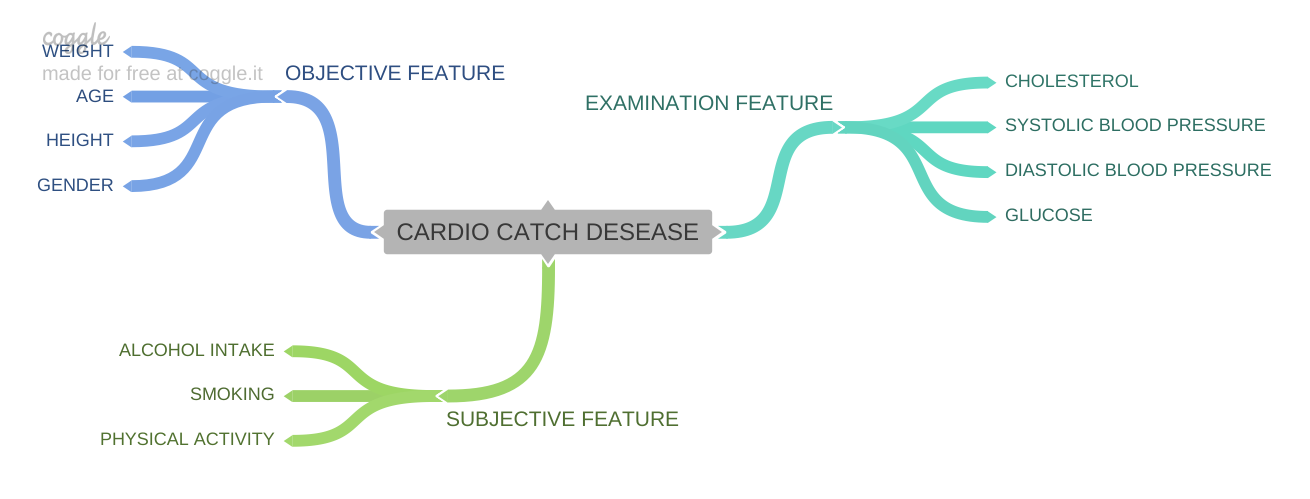

In [16]:
Image('../images/CARDIO_CATCH_DESEASE.png')

## 2.2. Hypothesis Creation

### 2.2.1. Objective Features Hypotheses

1. Both genders have the same proportion of cardiovascular diseases.

2. People over 40 have more than twice as many cardiovascular diseases, on average.

3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.

4. Between 40% and 50% of people over 100kg have cardiovascular disease.

5. People with heights below 150cm have half as many cardiovascular diseases on average.

### 2.2.2. Examination Features Hypotheses

1. People with cholesterol well above normal are twice as likely to have cardiovascular disease, on average.

2. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.

3. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.

4. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.

5. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 

6. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 


### 2.2.3. Subjective Features Hypotheses

1. People who drink have 20% less cardiovascular disease, on average.

2. People who practice physical activity have 30% less cardiovascular disease, on average.

3. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.

4. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.

5. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.

## 2.3. Final Hypothesis List

1. Both genders have the same proportion of cardiovascular diseases.

2. People over 40 have more than twice as many cardiovascular diseases, on average.

3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.

4. Between 40% and 50% of people over 100kg have cardiovascular disease.

5. People with heights below 150cm have half as many cardiovascular diseases on average.

6. People with cholesterol well above normal are twice as likely to have cardiovascular disease, on average.

7. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.

8. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.

9. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.

10. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 

11. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 

12. People who drink have 20% less cardiovascular disease, on average.

13. People who practice physical activity have 30% less cardiovascular disease, on average.

14. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.

15. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.

16. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.

## 2.4. Feature Engineering

**References:**

 - Blood Pressure Stages: https://www.webmd.com/hypertension-high-blood-pressure/guide/diastolic-and-systolic-blood-pressure-know-your-numbers#1
 
 - Weight Status: https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html

In [17]:
# create a feature for body mass index (BMI)
df02['bmi'] = np.round(df02['weight']/((df02['height']/100)**2), 2)

# create a feature for (ap_hi / api_lo)
df02['ap_hi/ap_lo'] = np.round(df02['ap_hi']/df02['ap_lo'], 2)

# create feature for people who smoke, drink and are not active
df02['bad_habits'] = df02[['smoke', 'alco', 'active']].apply(lambda x: 1 if (x['smoke'] == 1) & 
                                                                            (x['alco'] == 1) & (x['active'] == 0) else 0, 
                                                             axis=1) 

# create feature for people who drink and are active
df02['drink_active'] = df02[['alco', 'active']].apply(lambda x: 1 if (x['alco'] == 1) & (x['active'] == 1) else 0, 
                                                      axis=1)

In [18]:
# weight status based on BMI
df02['weight_status'] = df02['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                                    'healthy'     if (x >= 18.5) & (x < 25) else 
                                                    'overweight'  if (x >= 25) & (x < 30) else 
                                                    'obesity')

In [19]:
# blood pressure stages
df02['ap_stages'] = df02[['ap_hi', 'ap_lo']].apply(lambda x: 'hp_crisis'  if (x['ap_hi'] > 180) | (x['ap_lo'] > 120) else
                                                             'hp_stage_2' if (x['ap_hi'] >= 140) | (x['ap_lo'] >= 90) else
                                                             'hp_stage_1' if (x['ap_hi'] >= 130) | (x['ap_lo'] >= 80) else 
                                                             'elevated'   if (x['ap_hi'] >= 120) else 
                                                             'normal', axis=1)

In [20]:
# transformation cholesterol in categorical data
df02['cholesterol'] = df02['cholesterol'].apply(lambda x: 'normal' if x == 1 else 
                                                          'above_normal' if x == 2 else 
                                                          'well_above_normal')

In [21]:
# transformation glucose in categorical data
df02['gluc'] = df02['gluc'].apply(lambda x: 'normal' if x == 1 else 
                                            'above_normal' if x == 2 else 
                                            'well_above_normal')

In [22]:
# rearrange columns order
df02 = df02[['id', 'age', 'gender', 'height', 'weight', 'bmi', 'weight_status',
             'ap_hi', 'ap_lo', 'ap_hi/ap_lo', 'ap_stages', 'cholesterol', 'gluc', 
             'smoke', 'alco', 'active', 'bad_habits', 'drink_active', 'cardio']]

# 3.0. Data Filtering

In [23]:
df03 = df02.copy()

## 3.1. Filtering Rows

- Heights outside the range 135cm to 225cm will not be considered;

- Weight below 35 kg will not be considered.

- Blood pressure lower than 30 will not be considered.

- Blood pressure higher than 200 will not be considered.

- Dialostic blood pressure higher than systolic will not be considered.

In [24]:
# select heights between the range of 135cm to 225cm
df03 = df03[(df03['height'] >= 135) & (df03['height'] <= 225)]

# select weight below 35 kg
df03 = df03[df03['weight'] >= 35]

# select positive dialostic blood pressure and lower than 200
df03 = df03[(df03['ap_lo'] > 30) & (df03['ap_lo'] < 200)]

# select positive systolic blood pressure and lower than 200
df03 = df03[(df03['ap_hi'] > 30) & (df03['ap_hi'] < 200)]

# select systolic blood pressure higher than dialostic blood pressure
df03 = df03[df03['ap_hi'] > df03['ap_lo']]

# display dataset lose after filtering rows
np.round(df03.shape[0]/df02.shape[0], 2)

0.98

- Data filtering resulted in little data loss, keeping 98% of the dataset;

## 3.2. Columns Selection

In [25]:
df03 = df03.drop(['id'], axis=1)

# 4.0. Exploratory Data Analysis

In [26]:
df04 = df03.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

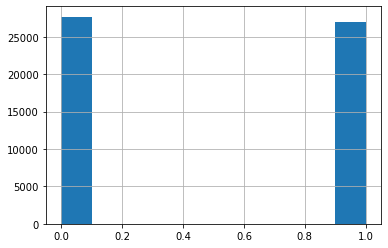

In [27]:
df04['cardio'].hist();

### 4.1.2. Numerical Variable

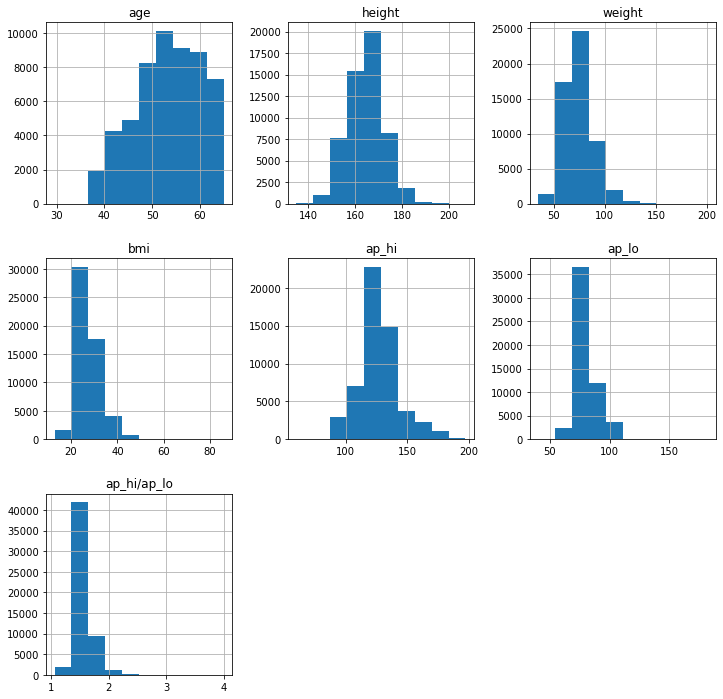

In [28]:
# select numerical attributes
num_attributes = df04[['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']]

# display histplot of numerical attributes
num_attributes.hist(figsize=(12,12));

#### 4.1.2.1. Age

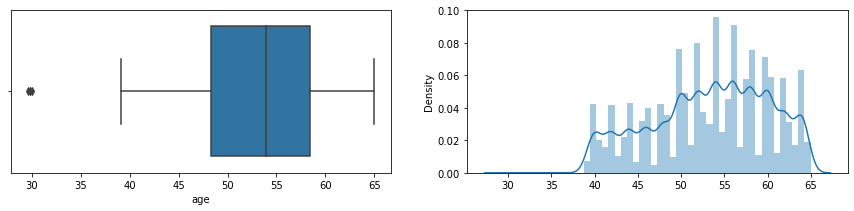

In [29]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='age', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['age']);

#### 4.1.2.2. Height

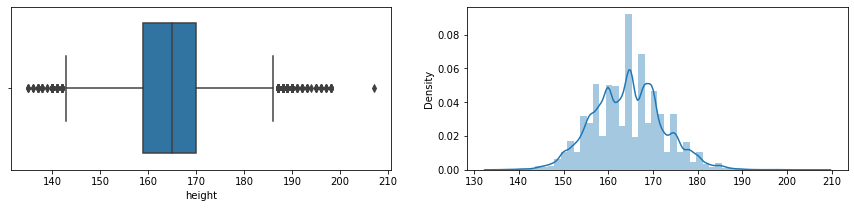

In [30]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='height', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['height']);

#### 4.1.2.3. Weight

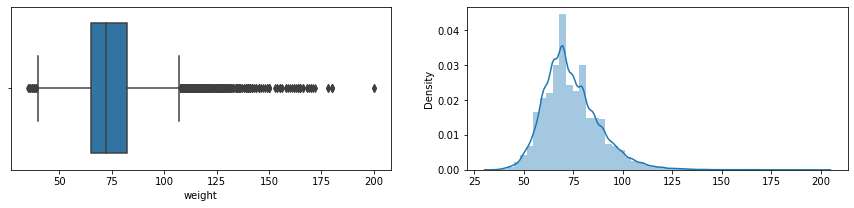

In [31]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='weight', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['weight']);

#### 4.1.2.4. BMI

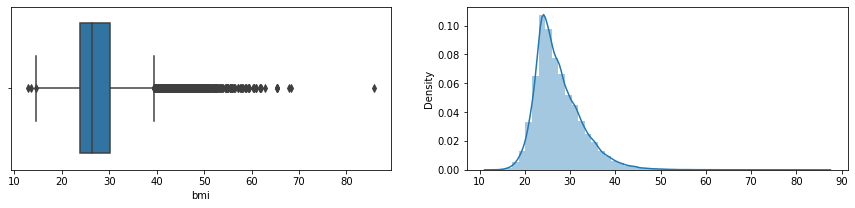

In [32]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='bmi', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['bmi']);

#### 4.1.2.5. Systolic Blood Pressure

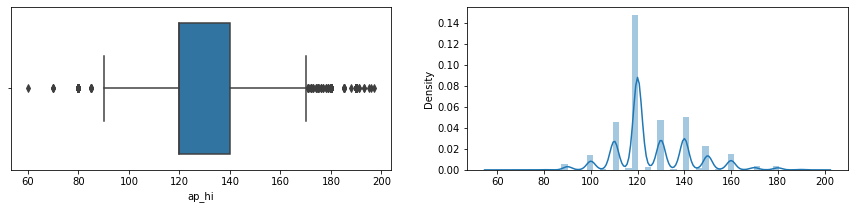

In [33]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_hi', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_hi']);

#### 4.1.2.6. Diastolic Blood Pressure

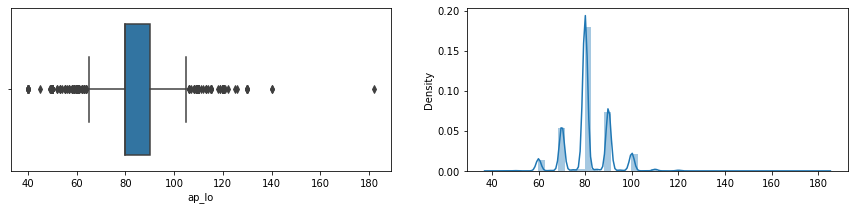

In [34]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_lo', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_lo']);

#### 4.1.2.7. Blood Pressure Ratio

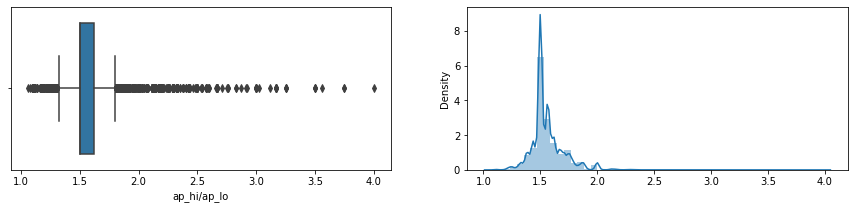

In [35]:
# setup figure size
plt.subplots(figsize=(15,3))

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ap_hi/ap_lo', data=num_attributes);

# distplot
plt.subplot(1, 2, 2)
sns.distplot(x=num_attributes['ap_hi/ap_lo']);

### 4.1.3. Categorical Variable

In [36]:
# select categorical and binary attributes
cat_attributes = df04[['gender', 'weight_status', 'ap_stages', 'cholesterol', 'gluc', 
                       'smoke', 'alco', 'active', 'bad_habits', 'drink_active']]

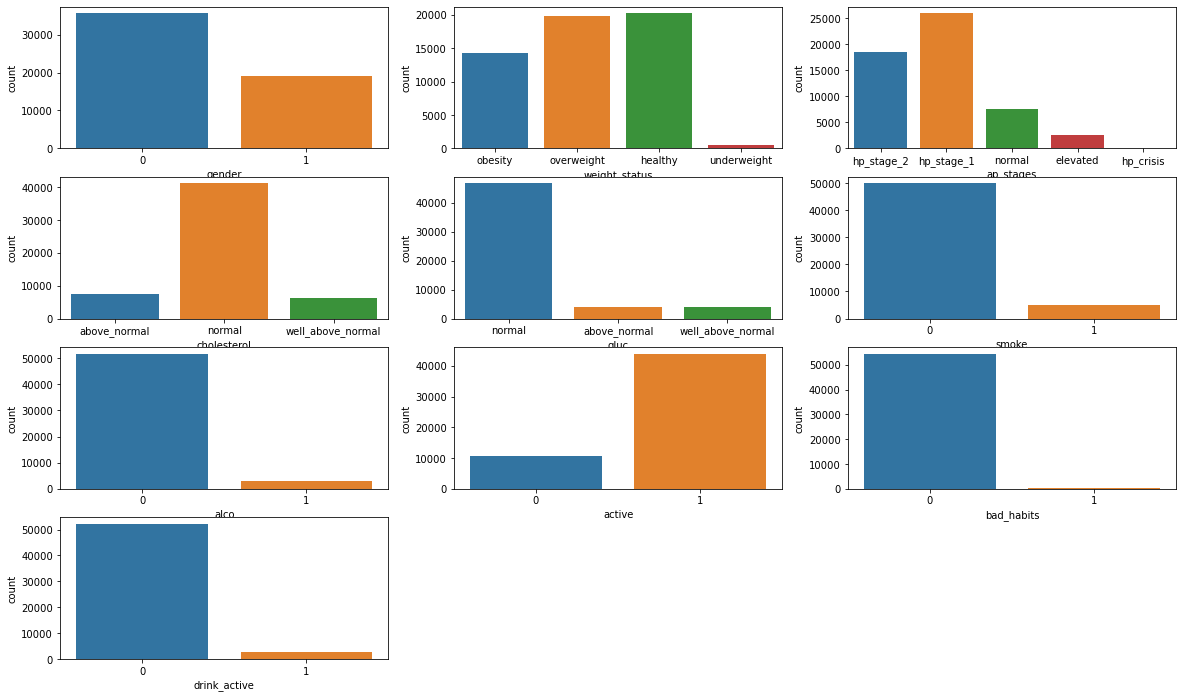

In [37]:
# setup figure size
plt.figure(figsize=(20,12))

# gender
plt.subplot(4, 3, 1)
sns.countplot(x=cat_attributes['gender']);

# weight_status
plt.subplot(4, 3, 2)
sns.countplot(x=cat_attributes['weight_status']);

# ap_stages
plt.subplot(4, 3, 3)
sns.countplot(x=cat_attributes['ap_stages']);

# cholesterol
plt.subplot(4, 3, 4)
sns.countplot(x=cat_attributes['cholesterol']);

# gluc
plt.subplot(4, 3, 5)
sns.countplot(x=cat_attributes['gluc']);

# smoke
plt.subplot(4, 3, 6)
sns.countplot(x=cat_attributes['smoke']);

# alco
plt.subplot(4, 3, 7)
sns.countplot(x=cat_attributes['alco']);

# active
plt.subplot(4, 3, 8)
sns.countplot(x=cat_attributes['active']);

# bad_habits
plt.subplot(4, 3, 9)
sns.countplot(x=cat_attributes['bad_habits']);

# drink_active
plt.subplot(4, 3, 10)
sns.countplot(x=cat_attributes['drink_active']);

## 4.2. Bivariate Analysis

### H1. Both genders have the same proportion of cardiovascular diseases.
**TRUE:** The generos have similar percentages of cardiovascular disease, with variance of 1% between them.

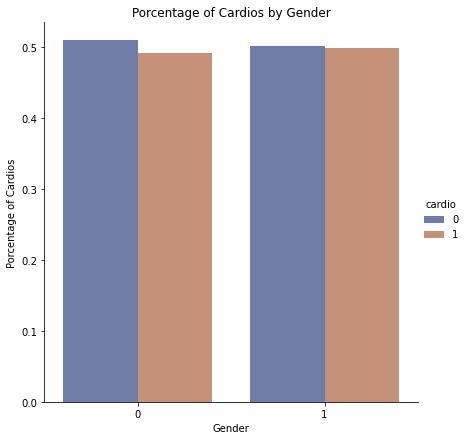

In [38]:
# number of cardios for gender
aux = df04[['gender', 'cardio']].groupby(['gender', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardios by gender
aux['pct_cardio_by_gender'] = aux[['gender', 'cardio_count']].apply(
                                lambda x: x['cardio_count']/aux[aux['gender'] == x['gender']]['cardio_count'].sum(), 
                                axis=1)
# display graph
graph = sns.catplot(data=aux, kind='bar', x='gender', y='pct_cardio_by_gender', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Gender', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Gender');

### H2. People over than 40 years old have more than twice as many cardiovascular diseases, on average.
**TRUE:** People over than 40 years old have 2.23 more cardio deseases than younger.

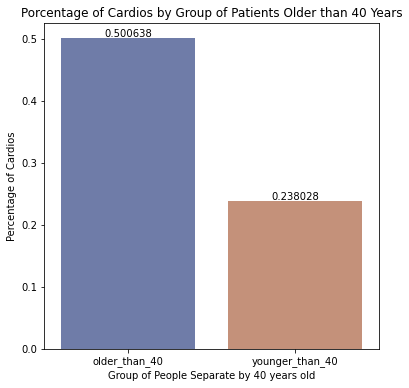

In [39]:
plt.figure(figsize=(6,6))

# select data of interest
aux = df04.loc[:, ['age', 'cardio']]

# separete people older and younger than 40
aux['older_40'] = aux['age'].apply(lambda x: 'older_than_40' if x > 40 else 'younger_than_40')

# calculate de the average of cardios by group of people separate by age
aux1 = aux[['older_40', 'cardio']].groupby('older_40').mean().reset_index()

# display graph
graph = sns.barplot(x='older_40', y='cardio', data=aux1, ci='sd', palette='dark', alpha=.6)
graph.bar_label(graph.containers[0]);
plt.xlabel('Group of People Separate by 40 years old')
plt.ylabel('Percentage of Cardios')
plt.title('Porcentage of Cardios by Group of Patients Older than 40 Years');

### H3. The higher the weight/height ratio, the greater the amount of cardiovascular disease.
**TRUE:** There is a corelation of 0.43 of BMI with the presence of cardiovascular disease.

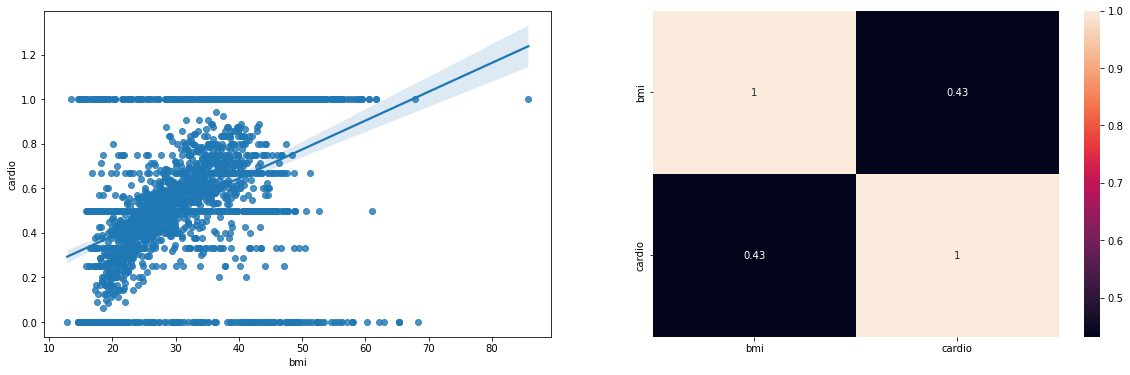

In [40]:
plt.figure(figsize=(20,6))

# average of people with cardio desease grouped by BMI
aux = df04[['bmi', 'cardio']].groupby('bmi').mean().reset_index()

# plot graph of linear regression
plt.subplot(1,2,1)
sns.regplot(x='bmi', y='cardio', data=aux);

# plot graph of correlation between cardios and BMI
plt.subplot(1,2,2)
sns.heatmap(aux.corr( method='pearson'), annot=True);

### H4. Between 40% and 50% of people over than 100kg have cardiovascular disease.
**FALSE:** Almost 70% of people over than 100kg have a cardiovascular disease.

In [41]:
# select data from people over than 100kg
aux = df04[df04['weight'] > 100]

# number of cardios from people over than 100kg
aux1 = aux[['cardio']].groupby('cardio').size().reset_index().rename(columns={0: 'cardio_count'})

# porcentage of cardios 
aux1['pct_cardio'] = aux1['cardio_count']/aux1['cardio_count'].sum()

# display table
aux1

,cardio,cardio_count,pct_cardio
0,0,779,0.318089
1,1,1670,0.681911


### H5. People with heights below 150cm have half as many cardiovascular diseases on average.
**FALSE:** Group of people smaller than 150cm have a similar percentage of cardiac as the larger ones.

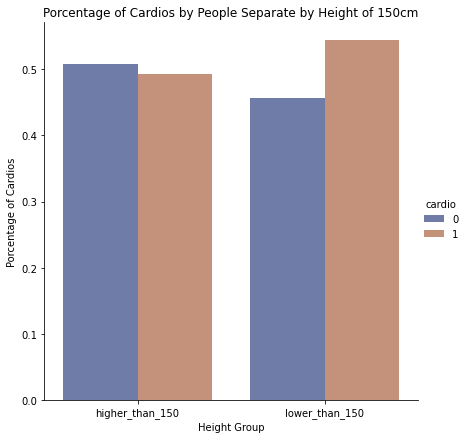

In [42]:
# select data of interest
aux = df04.loc[:, ['height', 'cardio']]

# create a feature separating people by height
aux['below_150'] = aux['height'].apply(lambda x: 'lower_than_150' if x < 150 else 'higher_than_150')

# number of cardios
aux1 = aux[['cardio','below_150']].groupby(['below_150', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardios for each height group
aux1['pct_cardio'] = aux1[['below_150', 'cardio_count']].apply(
                        lambda x: x['cardio_count']/aux1[aux1['below_150'] == x['below_150']]['cardio_count'].sum(), 
                        axis=1)

# display graph
graph = sns.catplot(data=aux1, kind='bar', x='below_150', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Height Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by People Separate by Height of 150cm');

### H6. People with cholesterol well above normal are twice as likely to have cardiovascular disease than people with normal cholesterol, on average.
**FALSE:** People with 'weel above normal' cholesterol have about 75% more cardiovascular disease than people with normal cholesterol

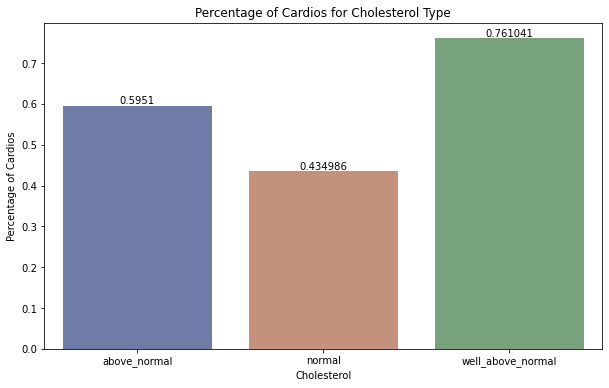

In [43]:
plt.figure(figsize=(10,6))

# average of cardio people by cholesterol status
aux = df04[['cholesterol', 'cardio']].groupby('cholesterol').mean().reset_index()

# display graph
graph = sns.barplot(x='cholesterol', y='cardio', data=aux, ci='sd', palette='dark', alpha=.6);
graph.bar_label(graph.containers[0]);
plt.xlabel('Cholesterol')
plt.ylabel('Percentage of Cardios')
plt.title('Percentage of Cardios for Cholesterol Type');

### H7. Less than 25% of people with normal cholesterol and glucose have cardiovascular disease.
**FALSE:** People with normal cholesterol and glucose have 42% of people with cardiovascular disease.

In [44]:
# select data of interest
aux = df04.loc[(df04['cholesterol'] == 1) & (df04['gluc'] == 1)]

# group cardio people
aux1 = aux[['cardio']].groupby('cardio').size().reset_index().rename(columns={0: 'cardio_count'})

# percentagem of cardios
aux1['pct_cardio'] = aux1['cardio_count']/aux1['cardio_count'].sum()

# display table
aux1

,cardio,cardio_count,pct_cardio


### H8. People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease.
**FALSE:** People with higher levels of glucose have a higher percentage of cardiovascular disease.

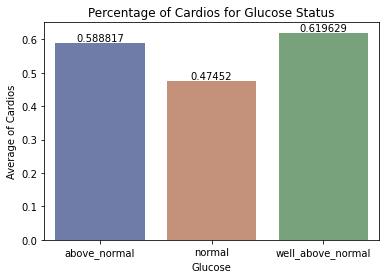

In [45]:
# average of cardios for glucose status
aux = df04[['gluc', 'cardio']].groupby('gluc').mean().reset_index()

# display graph
graph = sns.barplot(x='gluc', y='cardio', data=aux, ci='sd', palette='dark', alpha=.6)
graph.bar_label(graph.containers[0]);
plt.xlabel('Glucose')
plt.ylabel('Average of Cardios')
plt.title('Percentage of Cardios for Glucose Status');

### H9. People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg.
**FALSE:** People with a systolic blood pressure above 120 mmHg have more than twice as many diseases as those below, on average.

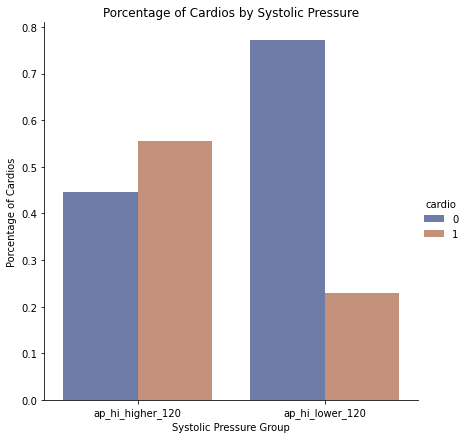

In [46]:
# select data of interest
aux = df04.loc[:, ['ap_hi', 'cardio']]

# create a feature separating people with systolic blood pressure above 120
aux['ap_hi_120'] = aux['ap_hi'].apply(lambda x: 'ap_hi_higher_120' if x >= 120 else 'ap_hi_lower_120')

# number of cardio by systolic blood pressure
aux1 = aux[['ap_hi_120', 'cardio']].groupby(['ap_hi_120', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_hi_120', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_hi_120'] == x['ap_hi_120']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_hi_120', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Systolic Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Systolic Pressure');

### H10. People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg. 
**FALSE:** People with a diastolic blood pressure above 80 mmHg have almost twice as many diseases as those below, on average.

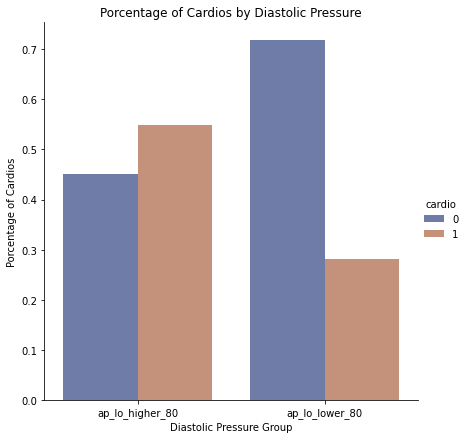

In [47]:
# select data of interest
aux = df04.loc[:, ['ap_lo', 'cardio']]

# create a feature separating people with diastolic blood pressure above 80
aux['ap_lo_80'] = aux['ap_lo'].apply(lambda x: 'ap_lo_higher_80' if x >= 80 else 'ap_lo_lower_80')

# number of cardio by diastolic blood pressure
aux1 = aux[['ap_lo_80', 'cardio']].groupby(['ap_lo_80', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_lo_80', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_lo_80'] == x['ap_lo_80']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_lo_80', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Diastolic Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Diastolic Pressure');

### H11. People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below. 
**TRUE:** People with blood pressure over 2 have 36% higher presence of cardiovascular disease.

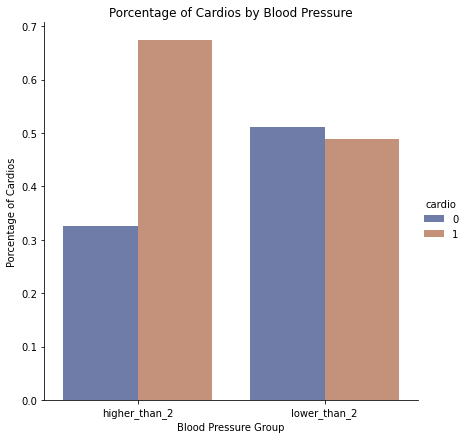

In [48]:
# select data of interest
aux = df04.loc[:, ['ap_hi/ap_lo', 'cardio']]

# create a feature separating people by ap_hi / api_lo
aux['ap_ratio'] = aux['ap_hi/ap_lo'].apply(lambda x: 'higher_than_2' if x >= 2 else 'lower_than_2')

# number of cardio by blood pressure
aux1 = aux[['ap_ratio', 'cardio']].groupby(['ap_ratio', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['ap_ratio', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['ap_ratio'] == x['ap_ratio']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='ap_ratio', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('Blood Pressure Group', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Blood Pressure');

### H12. People who drink have 20% less cardiovascular disease, on average.
**FALSE:** Peoples have similar cardio percentages independent of alcoholic habits.

In [49]:
# select data of interest
aux = df04.loc[:, ['alco', 'cardio']]

# average of cardios by alcohol habits
aux1 = aux[['alco', 'cardio']].groupby('alco').mean().reset_index()

# display table
aux1

,alco,cardio
0,0,0.495218
1,1,0.469518


### H13. People who practice physical activity have 30% less cardiovascular disease, on average.
**FALSE:** Peoples have similar cardio percentages independent of be active, with less than 5% of variance.

In [50]:
# select data of interest
aux = df04.loc[:, ['active', 'cardio']]

# average of cardios by active people
aux1 = aux[['active', 'cardio']].groupby('active').mean().reset_index()

# display table
aux1

,active,cardio
0,0,0.528000
1,1,0.485469


### H14. People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average.
**FALSE:** People with bad health habits have similar percentage of cardios.

In [51]:
# select data of interest
aux = df04.loc[:, ['bad_habits', 'cardio']]

# average of cardios by health habits
aux1 = aux[['bad_habits', 'cardio']].groupby('bad_habits').mean().reset_index()

# display table
aux1

,bad_habits,cardio
0,0,0.493688
1,1,0.526549


### H15. People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke.
**TRUE:** People who smoke have a similar percentage of cardios.

,smoke,cardio,cardio_count,pct_cardio
0,0,0,25106,0.503308
1,0,1,24776,0.496692
2,1,0,2594,0.535729
3,1,1,2248,0.464271


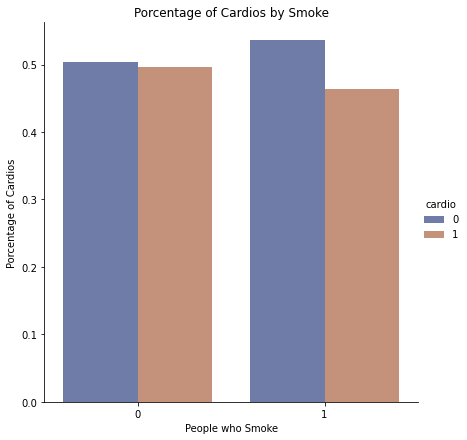

In [52]:
# select data of interest
aux = df04.loc[:, ['smoke', 'cardio']]

# average of cardios by health habits
aux1 = aux[['smoke', 'cardio']].groupby(['smoke', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['smoke', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['smoke'] == x['smoke']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='smoke', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('People who Smoke', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Smoke');

# display table
aux1

### H16. People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average.
**FALSE:** People who drink and exercise have similar percentage of cardiovascular disease.

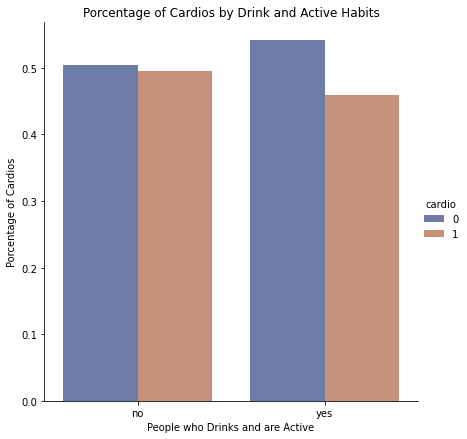

In [53]:
# select data of interest
aux = df04.loc[:, ['alco', 'active', 'cardio']]

# create a feature for people who drink and are active
aux['alco_active'] = aux[['alco', 'active']].apply(lambda x: 'yes' if (x['alco'] == 1) & (x['active'] == 1) else 
                                                             'no', axis=1)

# number of cardio by blood pressure
aux1 = aux[['alco_active', 'cardio']].groupby(['alco_active', 'cardio']).size().reset_index().rename(columns={0: 'cardio_count'})

# percentage of cardio
aux1['pct_cardio'] = aux1[['alco_active', 'cardio_count']].apply(
                            lambda x: x['cardio_count']/aux1[aux1['alco_active'] == x['alco_active']]['cardio_count'].sum(), 
                            axis=1)

# plot graph
graph = sns.catplot(data=aux1, kind='bar', x='alco_active', y='pct_cardio', hue='cardio',
                    ci='sd', palette='dark', alpha=.6, height=6);
graph.set_axis_labels('People who Drinks and are Active', 'Porcentage of Cardios')
plt.title('Porcentage of Cardios by Drink and Active Habits');

### 4.2.1. Hypotheses Summary

In [54]:
# hypothesis description
h1 = "Both genders have the same proportion of cardiovascular diseases."
h2 = "People over than 40 years old have more than twice as many cardiovascular diseases, on average."
h3 = "The higher the weight/height ratio, the greater the amount of cardiovascular disease."
h4 = "Between 40% and 50% of people over than 100kg have cardiovascular disease."
h5 = "People with heights below 150cm have half as many cardiovascular diseases on average."
h6 = "People with cholesterol well above normal are twice as likely to have cardiovascular disease than people with normal cholesterol, on average."
h7 = "Less than 25% of people with normal cholesterol and glucose have cardiovascular disease."
h8 = "People with all three glucose levels have a similar percentage (+/-5%) of cardiovascular disease."
h9 = "People with systolic blood pressure above 120 mmHg have 50% more cardiovascular diseases compared to those with pressure below 120 mmHg."
h10 = "People with a diastolic pressure above 80 mmHg have 50% more cardiovascular diseases compared to those with a pressure below 80 mmHg."
h11 = "People with blood pressure (ap_hi / api_lo) higher than 2 have 30% more cardiovascular diseases than those with pressure below."
h12 = "People who drink have 20% less cardiovascular disease, on average."
h13 = "People who practice physical activity have 30% less cardiovascular disease, on average."
h14 = "People who smoke, drink, and do not exercise have 3 times more cardiovascular disease on average."
h15 = "People who smoke have a similar percentage (+/-5%) of cardiovascular diseases compared to those who do not smoke."
h16 = "People who drink and exercise have 50% less cardiovascular disease compared to those who don't, on average."

# hypothesis results
hip_tab = {'ID': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'],
           'Hypothesis': [h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13, h14, h15, h16],
           'Conclusion': ['True', 'True', 'True', 'False', 'False', 'False', 'False', 'False', 
                          'False', 'False', 'True', 'False', 'False', 'False', 'True', 'False'],
           'Relevance':  ['Low', 'High', 'Medium', 'High', 'Low', 'High', 'Low', 'Medium', 'High', 'High', 
                          'High', 'Low', 'Low', 'Low', 'Low', 'Low']}

# create hypothesis dataframe
df_hyp = pd.DataFrame(hip_tab)

# display hypothesis summary
df_hyp

,ID,Hypothesis,Conclusion,Relevance
0,H1,Both genders have the same proportion of cardi...,True,Low
1,H2,People over than 40 years old have more than t...,True,High
2,H3,"The higher the weight/height ratio, the greate...",True,Medium
3,H4,Between 40% and 50% of people over than 100kg ...,False,High
4,H5,People with heights below 150cm have half as m...,False,Low
5,H6,People with cholesterol well above normal are ...,False,High
6,H7,Less than 25% of people with normal cholestero...,False,Low
7,H8,People with all three glucose levels have a si...,False,Medium
8,H9,People with systolic blood pressure above 120 ...,False,High
9,H10,People with a diastolic pressure above 80 mmHg...,False,High


## 4.3. Multivariate Analysis

In [55]:
# select numeric attributes
num_attributes = df04[['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']]

# select binary attributes
bin_attributes = df04[['smoke', 'alco', 'active', 'bad_habits', 'drink_active', 'cardio']]

# select attributes with categorical characteristics
cat_attributes = df04[['gender', 'weight_status', 'ap_stages', 'cholesterol', 'gluc']]

### 4.3.1. Numerical Attributes

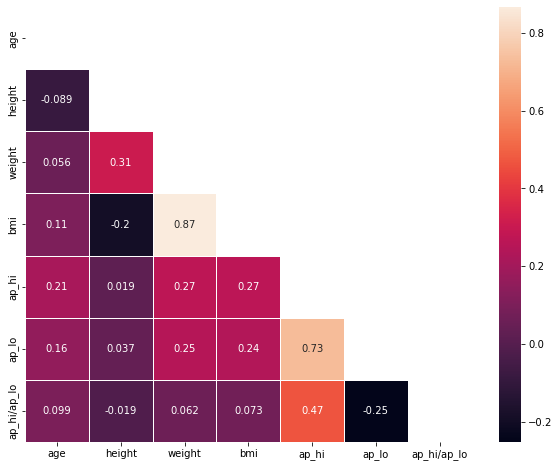

In [56]:
# calculate correlations by pearson
num_corr = num_attributes.corr(method='pearson')

# mask to only show values from below
mask = np.triu(np.ones_like(num_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(num_corr, mask=mask, linewidths=0.5, annot=True);

### 4.3.2. Binary Attributes

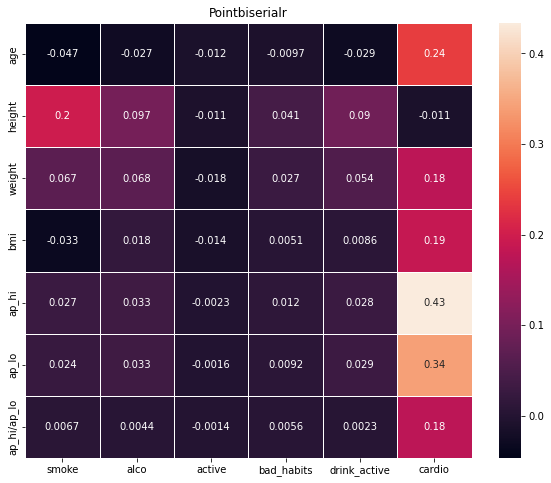

In [57]:
# numeric attributes columns
num_columns = list(num_attributes.columns)

# binary attributes columns
bin_columns = list(bin_attributes.columns)

# empty dict to store point bisserial correlations
bin_correlations = {}

for bin_col in bin_columns:
    # empty list for each binary attribute correlation 
    bin_correlations[bin_col] = []
    
    for num_col in num_columns:
        # calculate point bisserial correlations
        pb = pointbiserialr(bin_attributes[bin_col], num_attributes[num_col])
        
        # store correlation  
        bin_correlations[bin_col].append(pb[0])

# dataset of all point bisserial correlation 
pb_corr = pd.DataFrame(bin_correlations).set_index(num_attributes.columns)


# mask to only show values from below
mask = np.triu(np.ones_like(pb_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pb_corr, linewidths=0.5, annot=True);
plt.title("Pointbiserialr");

### 4.3.3. Categorical Attributes

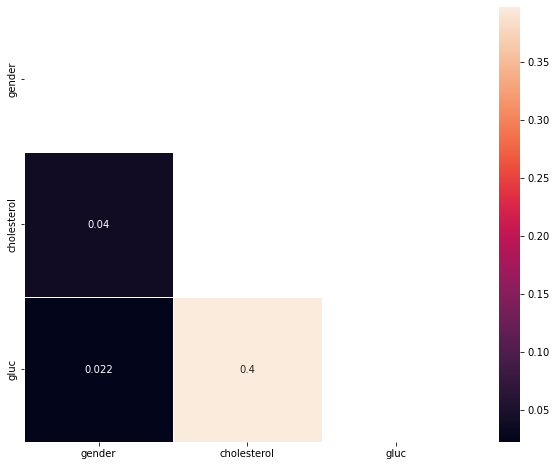

In [58]:
# cramer v of gender
a1 = cramer_v(cat_attributes['gender'], cat_attributes['gender'])
a2 = cramer_v(cat_attributes['gender'], cat_attributes['cholesterol'])
a3 = cramer_v(cat_attributes['gender'], cat_attributes['gluc'])

# cramer v of cholesterol
a4 = cramer_v(cat_attributes['cholesterol'], cat_attributes['gender'])
a5 = cramer_v(cat_attributes['cholesterol'], cat_attributes['cholesterol'])
a6 = cramer_v(cat_attributes['cholesterol'], cat_attributes['gluc'])

# cramer v of glucose
a7 = cramer_v(cat_attributes['gluc'], cat_attributes['gender'])
a8 = cramer_v(cat_attributes['gluc'], cat_attributes['cholesterol'])
a9 = cramer_v(cat_attributes['gluc'], cat_attributes['gluc'])

# dataset of all cramer v correlation 
cat_corr = pd.DataFrame( {'gender': [a1, a2, a3], 
                          'cholesterol': [a4, a5, a6],
                          'gluc': [a7, a8, a9]  })

# set index with columns name
cat_corr = cat_corr.set_index( cat_corr.columns )

# mask to only show values from below
mask = np.triu(np.ones_like(cat_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cat_corr, mask=mask, linewidths=0.5, annot=True);

# 5.0. Data Preparation

In [59]:
df05 = df04.copy()

## 5.1. Normalizing

## 5.2. Rescaling

In [60]:
rs = RobustScaler()
mms = MinMaxScaler()

# age - MinMax Scaler
df05['age'] = mms.fit_transform(df05[['age']].values)
# save age scaler object
pickle.dump(mms, open('../parameter/age_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# height - Robust Scaler
df05['height'] = rs.fit_transform(df05[['height']].values)
# save height scaler object
pickle.dump(rs, open('../parameter/height_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# weight - Robust Scaler
df05['weight'] = rs.fit_transform(df05[['weight']].values)
# save weight scaler object
pickle.dump(rs, open('../parameter/weight_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# BMI - MinMax Scaler
df05['bmi'] = mms.fit_transform(df05[['bmi']].values)
# save BMI scaler object
pickle.dump(mms, open('../parameter/bmi_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# ap_hi - Robust Scaler
df05['ap_hi'] = rs.fit_transform(df05[['ap_hi']].values)
# save ap_hi scaler object
pickle.dump(rs, open('../parameter/ap_hi_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# ap_lo - Robust Scaler
df05['ap_lo'] = rs.fit_transform(df05[['ap_lo']].values)
# save ap_lo scaler object
pickle.dump(rs, open('../parameter/ap_lo_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

# ap_hi/ap_lo - MinMax Scaler
df05['ap_hi/ap_lo'] = mms.fit_transform(df05[['ap_hi/ap_lo']].values)
# save ap_ratio scaler object
pickle.dump(mms, open('../parameter/ap_ratio_scaler.pkl', 'wb'))
pickle.dump(mms, open('../webapp/parameter/age_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [61]:
le = LabelEncoder()

In [62]:
# blood pressure category
df05['ap_stages'] = le.fit_transform(df05['ap_stages'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/ap_stages_encoder.pkl', 'wb'))
pickle.dump(le, open('../webapp/parameter/ap_stages_encoder.pkl', 'wb'))

# BMI class
df05['weight_status'] = le.fit_transform(df05['weight_status'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/weight_status_encoder.pkl', 'wb'))
pickle.dump(le, open('../webapp/parameter/ap_stages_encoder.pkl', 'wb'))

# cholesterol
df05['cholesterol'] = le.fit_transform(df05['cholesterol'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/cholesterol_encoder.pkl', 'wb'))
pickle.dump(le, open('../webapp/parameter/ap_stages_encoder.pkl', 'wb'))

# glucose
df05['gluc'] = le.fit_transform(df05['gluc'])
# save ap_ratio scaler object
pickle.dump(le, open('../parameter/gluc_encoder.pkl', 'wb'))
pickle.dump(le, open('../webapp/parameter/ap_stages_encoder.pkl', 'wb'))

In [63]:
df05.head().T

,47339,67456,12308,32557,664
age,0.857587,0.458322,0.799661,0.973156,0.734106
gender,0.000000,1.000000,1.000000,1.000000,0.000000
height,-1.000000,-0.272727,0.818182,0.727273,-0.454545
weight,0.470588,-0.117647,1.176471,0.235294,-0.705882
bmi,0.286204,0.189386,0.240400,0.171832,0.145091
weight_status,1.000000,2.000000,1.000000,2.000000,0.000000
ap_hi,0.500000,1.000000,1.500000,0.000000,0.000000
ap_lo,1.000000,1.000000,2.000000,0.200000,0.000000
ap_hi/ap_lo,0.129252,0.170068,0.149660,0.136054,0.149660
ap_stages,3.000000,3.000000,3.000000,2.000000,2.000000


### 5.3.2. Nature Transformation

# 6.0. Feature Selection

In [64]:
df06 = df05.copy()

## 6.1. Split Dataframe into Training and Validation Dataset

In [65]:
# features dataset
X = df06.drop(['cardio'],axis=1)

# response dataset
y = df06['cardio']

In [66]:
# split dataset into training  and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2. Manual Selection - Exploratory Data Analysis

In [67]:
manual_selection = ['age', 'weight', 'cholesterol', 'ap_hi', 'ap_lo', 'ap_hi/ap_lo']
# save features select object
pickle.dump(manual_selection, open('../parameter/feat_select_manual.pkl', 'wb'))
pickle.dump(manual_selection, open('../webapp/parameter/feat_select_manual.pkl', 'wb'))

# manual selection features
X_train_manual = X_train[manual_selection]
X_val_manual = X_val[manual_selection]

## 6.3. Boruta as Feature Selector

In [68]:
# prepare dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define Random Forest Regressor
extra_clf = ExtraTreesClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(extra_clf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	11
I

In [69]:
# best features from imbalanced dataset
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# check weak features
cols_weak = boruta.support_weak_.tolist()
cols_selected_weak = X_train.iloc[:, cols_weak].columns.to_list()

# not selected features
cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

# display best features
cols_selected_boruta
# save features select object
pickle.dump(cols_selected_boruta, open('../parameter/feat_select_boruta.pkl', 'wb'))
pickle.dump(cols_selected_boruta, open('../webapp/parameter/feat_select_boruta.pkl', 'wb'))

### 6.3.1. Attributes Selection as Boruta

In [70]:
# select features by boruta
X_train_boruta = X_train[cols_selected_boruta]
X_val_boruta = X_val[cols_selected_boruta]

## 6.4. PCA - Principal Component Analysis

In [71]:
# define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = decomposition.PCA().fit(X_train)

In [72]:
# return autovalores
pca.explained_variance_ratio_

# accumulated sum of autovalores
np.cumsum(pca.explained_variance_ratio_)

# determine the number of eigenvalues that represents 95% of the variability
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.98)

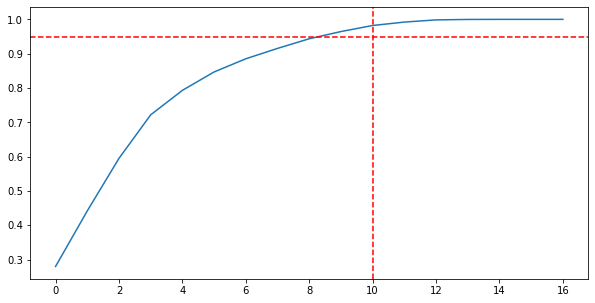

In [73]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(k, color='red', linestyle='--')
plt.axhline(0.95, color='red', linestyle='--')

### 6.4.1. Attributes Selection as PCA

In [74]:
# define the number of eigenvectors (autovetor) + eigenvalues (autovalores)
pca = decomposition.PCA().fit( X_train )
k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.98)

# change data to new space
pca = decomposition.PCA(k).fit(X_train)
# save features select object
pickle.dump(pca, open('../parameter/feat_select_pca.pkl', 'wb'))
pickle.dump(pca, open('../webapp/parameter/feat_select_pca.pkl', 'wb'))

# select features by pca
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

## 6.5. Feature Importance - Random Forest

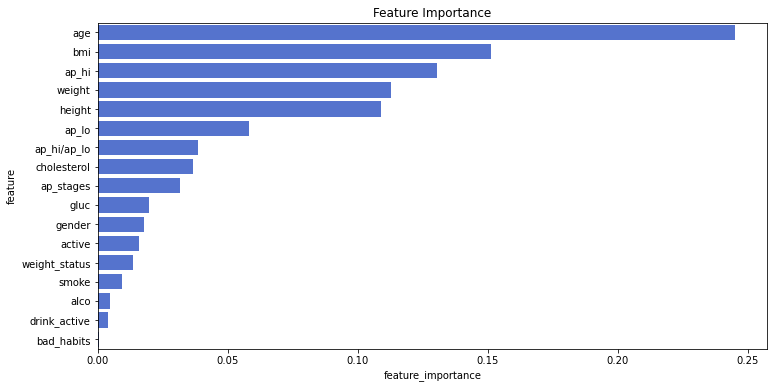

In [75]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
            .set_title('Feature Importance');

In [76]:
# features importance higher than 0.02
feat_imp_select = feat_imp.loc[feat_imp['feature_importance'] > 0.02]
feat_imp_select

,feature,feature_importance
0,age,0.245222
1,bmi,0.151175
2,ap_hi,0.130387
3,weight,0.112951
4,height,0.109073
5,ap_lo,0.058127
6,ap_hi/ap_lo,0.038683
7,cholesterol,0.036697
8,ap_stages,0.031730


In [77]:
# top features list
feat_list = feat_imp_select['feature'].to_list()
# save features select object
pickle.dump(feat_list, open('../parameter/feat_select_imp.pkl', 'wb'))
pickle.dump(feat_list, open('../webapp/parameter/feat_select_imp.pkl', 'wb'))

# display features select
feat_list

['age',
 'bmi',
 'ap_hi',
 'weight',
 'height',
 'ap_lo',
 'ap_hi/ap_lo',
 'cholesterol',
 'ap_stages']

### 6.5.1. Attributes Selection as Feature Importance

In [78]:
# select features by importance
X_train_feat_imp = X_train[feat_list].copy()
X_val_feat_imp = X_val[feat_list].copy()

# 7.0. Machine Learning Model

Metrica de referencia para o modelo será o Recall por priorizar os resultados True Positive, para esse tipo de negócio é mais importante detectar do que não tdetectar e ser positivo, podendo criar graves problemas para os clientes.

**References:**

- Interpretação das Métricas: https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

- Evaluation Metrics for Evaluation Models: https://neptune.ai/blog/evaluation-metrics-binary-classification#:~:text=Simply%20put%20a%20classification%20metric,to%20classes%3A%20positive%20and%20negative.

In [79]:
# select data for machine learning models
x_train = X_train_feat_imp.copy()
x_val = X_val_feat_imp.copy()

# manual feature selection
x_train_manual = X_train_manual.copy()
x_val_manual = X_val_manual.copy()

# boruta feature selection
x_train_boruta = X_train_boruta.copy()
x_val_boruta = X_val_boruta.copy()

# pca feature selection
x_train_pca = X_train_pca.copy()
x_val_pca = X_val_pca.copy()

# importance feature selection
x_train_feat_imp = X_train_feat_imp.copy()
x_val_feat_imp = X_val_feat_imp.copy()

## 7.1. Random Forest Classifier 

In [80]:
# model definition
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train, y_train)

# model definition by manual selection
model_rf_manual = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_manual, y_train)

# model definition by boruta
model_rf_boruta = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_boruta, y_train)

# model definition by pca
model_rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_pca, y_train)

# model definition by importance
model_rf_feat_imp = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train_feat_imp, y_train)

### 7.1.1. Random Forest Classifier - Performance

In [81]:
# prediction
pred_rf = model_rf.predict(x_val)

# evaluate performance of model
rf_performance = pd.DataFrame(['Random Forest Classifier',
                               accuracy_score(y_val, pred_rf), 
                               precision_score(y_val, pred_rf), 
                               recall_score(y_val, pred_rf), 
                               f1_score(y_val, pred_rf),
                               roc_auc_score(y_val, pred_rf)]).T

# set metris as columns name
rf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.703883,0.699623,0.692968,0.69628,0.703665


#### 7.1.1. Random Forest Classifier - Performance - Manual Selection

In [82]:
# prediction
pred_rf_manual = model_rf_manual.predict(x_val_manual)

# evaluate performance of model
rf_performance_manual = pd.DataFrame(['Random Forest Classifier - Manual Selection',
                                      accuracy_score(y_val, pred_rf_manual), 
                                      precision_score(y_val, pred_rf_manual), 
                                      recall_score(y_val, pred_rf_manual), 
                                      f1_score(y_val, pred_rf_manual),
                                      roc_auc_score(y_val, pred_rf_manual)]).T

# set metris as columns name
rf_performance_manual.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_manual

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Manual Selection,0.677021,0.66964,0.672263,0.670949,0.676926


#### 7.1.2. Random Forest Classifier - Performance - Boruta

In [83]:
# prediction
pred_rf_boruta = model_rf_boruta.predict(x_val_boruta)

# evaluate performance of model
rf_performance_boruta = pd.DataFrame(['Random Forest Classifier - Boruta',
                                      accuracy_score(y_val, pred_rf_boruta), 
                                      precision_score(y_val, pred_rf_boruta), 
                                      recall_score(y_val, pred_rf_boruta), 
                                      f1_score(y_val, pred_rf_boruta),
                                      roc_auc_score(y_val, pred_rf_boruta)]).T

# set metris as columns name
rf_performance_boruta.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_boruta

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Boruta,0.680037,0.676209,0.665361,0.670741,0.679744


#### 7.1.3. Random Forest Classifier - Performance - PCA

In [84]:
# prediction
pred_rf_pca = model_rf_pca.predict(x_val_pca)

# evaluate performance of model
rf_performance_pca = pd.DataFrame(['Random Forest Classifier - PCA',
                                   accuracy_score(y_val, pred_rf_pca), 
                                   precision_score(y_val, pred_rf_pca), 
                                   recall_score(y_val, pred_rf_pca), 
                                   f1_score(y_val, pred_rf_pca),
                                   roc_auc_score(y_val, pred_rf_pca)]).T

# set metris as columns name
rf_performance_pca.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_pca

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - PCA,0.697305,0.691473,0.689797,0.690634,0.697155


#### 7.1.4. Random Forest Classifier - Performance - Feature Importance

In [85]:
# prediction
pred_rf_feat_imp = model_rf_feat_imp.predict(x_val_feat_imp)

# evaluate performance of model
rf_performance_feat_imp = pd.DataFrame(['Random Forest Classifier - Feat. Importance',
                                        accuracy_score(y_val, pred_rf_feat_imp), 
                                        precision_score(y_val, pred_rf_feat_imp), 
                                        recall_score(y_val, pred_rf_feat_imp), 
                                        f1_score(y_val, pred_rf_feat_imp),
                                        roc_auc_score(y_val, pred_rf_feat_imp)]).T

# set metris as columns name
rf_performance_feat_imp.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance_feat_imp

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier - Feat. Importance,0.705528,0.702156,0.692595,0.697342,0.705269


#### 7.1.5. Random Forest Classifier - Performance Comparative

In [86]:
# performance comparative
comp_performance = pd.concat([rf_performance, 
                              rf_performance_manual, 
                              rf_performance_boruta, 
                              rf_performance_pca, 
                              rf_performance_feat_imp]).reset_index(drop=True)

# display performance for each feature selection
comp_performance.style.highlight_max(color='darkorange')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.703883,0.699623,0.692968,0.696280,0.703665
1,Random Forest Classifier - Manual Selection,0.677021,0.669640,0.672263,0.670949,0.676926
2,Random Forest Classifier - Boruta,0.680037,0.676209,0.665361,0.670741,0.679744
3,Random Forest Classifier - PCA,0.697305,0.691473,0.689797,0.690634,0.697155
4,Random Forest Classifier - Feat. Importance,0.705528,0.702156,0.692595,0.697342,0.705269


### 7.1.2. Random Forest Classifier - Cross-Validation

In [87]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv = pd.DataFrame({'Model': 'Random Forest Classifier', 
                                  'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                  'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                  'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                  'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                  'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                 index=[0])

# display model perfomance
rf_performance_cv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier,0.698919 +/- 0.010223,0.699578 +/- 0.0083,0.686055 +/- 0.017824,0.692695 +/- 0.012553,0.757936 +/- 0.00931


#### 7.1.2.1. Random Forest Classifier - Cross-Validation - Manual Selection

In [88]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_manual, x_train_manual, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_manual = pd.DataFrame({'Model': 'Random Forest Classifier - Manual Selection', 
                                         'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                         'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                         'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                         'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                         'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                        index=[0])

# display model perfomance
rf_performance_cv_manual

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Manual Selection,0.680006 +/- 0.009204,0.675859 +/- 0.008315,0.6789 +/- 0.016141,0.677313 +/- 0.010994,0.738846 +/- 0.009344


#### 7.1.2.2. Random Forest Classifier - Cross-Validation - Boruta

In [89]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_boruta, x_train_boruta, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_boruta = pd.DataFrame({'Model': 'Random Forest Classifier - Boruta', 
                                         'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                         'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                         'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                         'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                         'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                        index=[0])

# display model perfomance
rf_performance_cv_boruta

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Boruta,0.675986 +/- 0.005793,0.677747 +/- 0.003863,0.658035 +/- 0.013961,0.66769 +/- 0.008519,0.736489 +/- 0.006171


#### 7.1.2.3. Random Forest Classifier - Cross-Validation - PCA

In [90]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_pca, x_train_pca, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_pca = pd.DataFrame({'Model': 'Random Forest Classifier - PCA', 
                                      'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                      'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                      'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                      'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                      'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                     index=[0])

# display model perfomance
rf_performance_cv_pca

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - PCA,0.688229 +/- 0.003504,0.687916 +/- 0.002503,0.677099 +/- 0.007202,0.682454 +/- 0.004682,0.742384 +/- 0.005262


#### 7.1.2.4. Random Forest Classifier - Cross-Validation - Feature Importance

In [91]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf_feat_imp, x_train_feat_imp, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv_feat_imp= pd.DataFrame({'Model': 'Random Forest Classifier - Feat. Importance', 
                                          'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                          'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                          'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                          'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                          'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                         index=[0])

# display model perfomance
rf_performance_cv_feat_imp

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier - Feat. Importance,0.696087 +/- 0.009319,0.697323 +/- 0.007477,0.681577 +/- 0.016736,0.689306 +/- 0.011605,0.757149 +/- 0.008833


#### 7.1.2.5. Random Forest Classifier - Cross-Validation - Performance Comparative

In [92]:
# performance comparative
comp_performance_cv = pd.concat([rf_performance_cv, 
                                 rf_performance_cv_manual, 
                                 rf_performance_cv_boruta, 
                                 rf_performance_cv_pca, 
                                 rf_performance_cv_feat_imp]).reset_index(drop=True)

# display performance for each feature selection
comp_performance_cv.style.highlight_max(color='darkorange')

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier,0.698919 +/- 0.010223,0.699578 +/- 0.0083,0.686055 +/- 0.017824,0.692695 +/- 0.012553,0.757936 +/- 0.00931
1,Random Forest Classifier - Manual Selection,0.680006 +/- 0.009204,0.675859 +/- 0.008315,0.6789 +/- 0.016141,0.677313 +/- 0.010994,0.738846 +/- 0.009344
2,Random Forest Classifier - Boruta,0.675986 +/- 0.005793,0.677747 +/- 0.003863,0.658035 +/- 0.013961,0.66769 +/- 0.008519,0.736489 +/- 0.006171
3,Random Forest Classifier - PCA,0.688229 +/- 0.003504,0.687916 +/- 0.002503,0.677099 +/- 0.007202,0.682454 +/- 0.004682,0.742384 +/- 0.005262
4,Random Forest Classifier - Feat. Importance,0.696087 +/- 0.009319,0.697323 +/- 0.007477,0.681577 +/- 0.016736,0.689306 +/- 0.011605,0.757149 +/- 0.008833


## 7.2. XGBoost Classifier

model_xgb = XGBClassifier(objective='multi:softmax',
                          num_class=2,
                          n_estimators=100,
                          eta=0.01,
                          max_depth=10,
                          subsample=0.7,
                          colsample_bytree=0.9).fit(X_train, y_train)

In [93]:
model_xgb = XGBClassifier(random_state=42).fit(x_train, y_train)

[12:18:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 7.2.1. XGBoost Classifier - Performance

In [94]:
# prediction
pred_xgb = model_xgb.predict(x_val)

# evaluate performance of model
xgb_performance = pd.DataFrame(['XGBoost Classifier',
                                accuracy_score(y_val, pred_xgb), 
                                precision_score(y_val, pred_xgb), 
                                recall_score(y_val, pred_xgb), 
                                f1_score(y_val, pred_xgb),
                                roc_auc_score(y_val, pred_xgb)]).T

# set metris as columns name
xgb_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
xgb_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost Classifier,0.728826,0.744833,0.678978,0.710383,0.727831


### 7.2.2. XGBoost Classifier - Cross-Validation

In [95]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_xgb, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
xgb_performance_cv = pd.DataFrame({'Model': 'XGBoost Classifier', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
xgb_performance_cv

[12:18:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost Classifier,0.725051 +/- 0.009866,0.742471 +/- 0.007404,0.680146 +/- 0.017299,0.709892 +/- 0.012535,0.788685 +/- 0.006551


## 7.3. CatBoost Classifier - RETIRAR

model_cat = CatBoostClassifier(objective=None,
                                        eval_metric='F1',
                                        n_estimators=100,
                                        eta=0.01,
                                        max_depth=10,
                                        subsample=0.7, 
                                        verbose=0).fit(X_train, y_train)

model_cat = CatBoostClassifier(n_estimators=100, 
                               depth=3, 
                               learning_rate=0.1, 
                               loss_function='Logloss')

model_cat.fit(X_train, y_train, verbose=0)

In [96]:
model_cat = CatBoostClassifier(random_state=42).fit(x_train, y_train, verbose=0)

### 7.3.1. CatBoost Classifier - Performance

In [97]:
# prediction
pred_cat = model_cat.predict(x_val)

# evaluate performance of model
cat_performance = pd.DataFrame(['CatBoost Classifier',
                                accuracy_score(y_val, pred_cat), 
                                precision_score(y_val, pred_cat), 
                                recall_score(y_val, pred_cat), 
                                f1_score(y_val, pred_cat),
                                roc_auc_score(y_val, pred_cat)]).T

# set metris as columns name
cat_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
cat_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,CatBoost Classifier,0.731293,0.748766,0.679351,0.712372,0.730256


### 7.3.2. CatBoost Classifier - Cross-Validation

In [98]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_cat, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
cat_performance_cv = pd.DataFrame({'Model': 'CatBoost Classifier', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
cat_performance_cv

Learning rate set to 0.049456
0:	learn: 0.6788381	total: 34.3ms	remaining: 34.3s
1:	learn: 0.6657533	total: 60.1ms	remaining: 30s
2:	learn: 0.6537942	total: 84ms	remaining: 27.9s
3:	learn: 0.6436839	total: 114ms	remaining: 28.3s
4:	learn: 0.6341159	total: 141ms	remaining: 28s
5:	learn: 0.6256989	total: 169ms	remaining: 27.9s
6:	learn: 0.6182842	total: 193ms	remaining: 27.3s
7:	learn: 0.6114717	total: 217ms	remaining: 27s
8:	learn: 0.6053277	total: 247ms	remaining: 27.2s
9:	learn: 0.5998842	total: 266ms	remaining: 26.3s
10:	learn: 0.5947654	total: 291ms	remaining: 26.2s
11:	learn: 0.5902257	total: 320ms	remaining: 26.4s
12:	learn: 0.5862080	total: 356ms	remaining: 27s
13:	learn: 0.5824264	total: 386ms	remaining: 27.2s
14:	learn: 0.5789117	total: 426ms	remaining: 28s
15:	learn: 0.5759969	total: 468ms	remaining: 28.8s
16:	learn: 0.5734535	total: 535ms	remaining: 30.9s
17:	learn: 0.5709254	total: 581ms	remaining: 31.7s
18:	learn: 0.5686710	total: 662ms	remaining: 34.2s
19:	learn: 0.5667872

166:	learn: 0.5354589	total: 5.24s	remaining: 26.1s
167:	learn: 0.5353821	total: 5.27s	remaining: 26.1s
168:	learn: 0.5353347	total: 5.31s	remaining: 26.1s
169:	learn: 0.5352922	total: 5.36s	remaining: 26.2s
170:	learn: 0.5352627	total: 5.41s	remaining: 26.2s
171:	learn: 0.5352478	total: 5.44s	remaining: 26.2s
172:	learn: 0.5352067	total: 5.47s	remaining: 26.2s
173:	learn: 0.5351734	total: 5.5s	remaining: 26.1s
174:	learn: 0.5351258	total: 5.52s	remaining: 26s
175:	learn: 0.5350907	total: 5.55s	remaining: 26s
176:	learn: 0.5350448	total: 5.57s	remaining: 25.9s
177:	learn: 0.5350075	total: 5.59s	remaining: 25.8s
178:	learn: 0.5349787	total: 5.62s	remaining: 25.8s
179:	learn: 0.5349126	total: 5.66s	remaining: 25.8s
180:	learn: 0.5348933	total: 5.68s	remaining: 25.7s
181:	learn: 0.5348573	total: 5.71s	remaining: 25.7s
182:	learn: 0.5347994	total: 5.74s	remaining: 25.6s
183:	learn: 0.5347580	total: 5.76s	remaining: 25.5s
184:	learn: 0.5347202	total: 5.79s	remaining: 25.5s
185:	learn: 0.534

328:	learn: 0.5280962	total: 11.8s	remaining: 24.1s
329:	learn: 0.5280422	total: 11.8s	remaining: 24s
330:	learn: 0.5279932	total: 11.9s	remaining: 24s
331:	learn: 0.5279532	total: 11.9s	remaining: 23.9s
332:	learn: 0.5278895	total: 11.9s	remaining: 23.9s
333:	learn: 0.5278445	total: 11.9s	remaining: 23.8s
334:	learn: 0.5277844	total: 12s	remaining: 23.7s
335:	learn: 0.5277114	total: 12s	remaining: 23.7s
336:	learn: 0.5276325	total: 12s	remaining: 23.6s
337:	learn: 0.5275607	total: 12s	remaining: 23.6s
338:	learn: 0.5275147	total: 12.1s	remaining: 23.5s
339:	learn: 0.5274591	total: 12.1s	remaining: 23.5s
340:	learn: 0.5274100	total: 12.1s	remaining: 23.4s
341:	learn: 0.5273713	total: 12.1s	remaining: 23.4s
342:	learn: 0.5273133	total: 12.2s	remaining: 23.3s
343:	learn: 0.5272837	total: 12.2s	remaining: 23.3s
344:	learn: 0.5272297	total: 12.2s	remaining: 23.2s
345:	learn: 0.5271764	total: 12.3s	remaining: 23.2s
346:	learn: 0.5271031	total: 12.3s	remaining: 23.1s
347:	learn: 0.5271018	to

492:	learn: 0.5208291	total: 15.6s	remaining: 16s
493:	learn: 0.5207927	total: 15.6s	remaining: 16s
494:	learn: 0.5207577	total: 15.7s	remaining: 16s
495:	learn: 0.5207274	total: 15.7s	remaining: 15.9s
496:	learn: 0.5206828	total: 15.7s	remaining: 15.9s
497:	learn: 0.5206300	total: 15.8s	remaining: 15.9s
498:	learn: 0.5205892	total: 15.8s	remaining: 15.8s
499:	learn: 0.5205277	total: 15.8s	remaining: 15.8s
500:	learn: 0.5204835	total: 15.8s	remaining: 15.8s
501:	learn: 0.5204189	total: 15.9s	remaining: 15.7s
502:	learn: 0.5203600	total: 15.9s	remaining: 15.7s
503:	learn: 0.5203266	total: 15.9s	remaining: 15.7s
504:	learn: 0.5202770	total: 15.9s	remaining: 15.6s
505:	learn: 0.5202025	total: 16s	remaining: 15.6s
506:	learn: 0.5201719	total: 16s	remaining: 15.5s
507:	learn: 0.5201040	total: 16s	remaining: 15.5s
508:	learn: 0.5200664	total: 16s	remaining: 15.5s
509:	learn: 0.5200412	total: 16s	remaining: 15.4s
510:	learn: 0.5200027	total: 16.1s	remaining: 15.4s
511:	learn: 0.5199598	total:

659:	learn: 0.5142705	total: 19.8s	remaining: 10.2s
660:	learn: 0.5142337	total: 19.9s	remaining: 10.2s
661:	learn: 0.5141971	total: 19.9s	remaining: 10.2s
662:	learn: 0.5141792	total: 19.9s	remaining: 10.1s
663:	learn: 0.5141427	total: 19.9s	remaining: 10.1s
664:	learn: 0.5141104	total: 20s	remaining: 10.1s
665:	learn: 0.5140814	total: 20s	remaining: 10s
666:	learn: 0.5140549	total: 20s	remaining: 9.99s
667:	learn: 0.5140274	total: 20s	remaining: 9.96s
668:	learn: 0.5140045	total: 20.1s	remaining: 9.93s
669:	learn: 0.5139530	total: 20.1s	remaining: 9.91s
670:	learn: 0.5139254	total: 20.2s	remaining: 9.88s
671:	learn: 0.5138669	total: 20.2s	remaining: 9.86s
672:	learn: 0.5138310	total: 20.2s	remaining: 9.83s
673:	learn: 0.5137938	total: 20.3s	remaining: 9.8s
674:	learn: 0.5137438	total: 20.3s	remaining: 9.77s
675:	learn: 0.5136866	total: 20.3s	remaining: 9.74s
676:	learn: 0.5136577	total: 20.4s	remaining: 9.71s
677:	learn: 0.5136566	total: 20.4s	remaining: 9.68s
678:	learn: 0.5136180	t

823:	learn: 0.5085015	total: 26.3s	remaining: 5.62s
824:	learn: 0.5084711	total: 26.3s	remaining: 5.58s
825:	learn: 0.5084304	total: 26.3s	remaining: 5.55s
826:	learn: 0.5084042	total: 26.4s	remaining: 5.51s
827:	learn: 0.5084035	total: 26.4s	remaining: 5.48s
828:	learn: 0.5084027	total: 26.4s	remaining: 5.45s
829:	learn: 0.5083522	total: 26.4s	remaining: 5.42s
830:	learn: 0.5083174	total: 26.5s	remaining: 5.38s
831:	learn: 0.5082634	total: 26.5s	remaining: 5.35s
832:	learn: 0.5082083	total: 26.5s	remaining: 5.32s
833:	learn: 0.5081938	total: 26.6s	remaining: 5.29s
834:	learn: 0.5081397	total: 26.6s	remaining: 5.25s
835:	learn: 0.5081189	total: 26.6s	remaining: 5.22s
836:	learn: 0.5080761	total: 26.6s	remaining: 5.19s
837:	learn: 0.5080426	total: 26.7s	remaining: 5.16s
838:	learn: 0.5080053	total: 26.7s	remaining: 5.12s
839:	learn: 0.5079525	total: 26.7s	remaining: 5.09s
840:	learn: 0.5079195	total: 26.7s	remaining: 5.06s
841:	learn: 0.5078700	total: 26.8s	remaining: 5.02s
842:	learn: 

988:	learn: 0.5031438	total: 31.3s	remaining: 349ms
989:	learn: 0.5030991	total: 31.4s	remaining: 317ms
990:	learn: 0.5030615	total: 31.4s	remaining: 285ms
991:	learn: 0.5030186	total: 31.4s	remaining: 254ms
992:	learn: 0.5030033	total: 31.5s	remaining: 222ms
993:	learn: 0.5029663	total: 31.5s	remaining: 190ms
994:	learn: 0.5029571	total: 31.5s	remaining: 158ms
995:	learn: 0.5029210	total: 31.6s	remaining: 127ms
996:	learn: 0.5028967	total: 31.6s	remaining: 95.1ms
997:	learn: 0.5028379	total: 31.7s	remaining: 63.4ms
998:	learn: 0.5027770	total: 31.7s	remaining: 31.7ms
999:	learn: 0.5027425	total: 31.8s	remaining: 0us
Learning rate set to 0.049456
0:	learn: 0.6790189	total: 88.4ms	remaining: 1m 28s
1:	learn: 0.6660483	total: 129ms	remaining: 1m 4s
2:	learn: 0.6544739	total: 187ms	remaining: 1m 2s
3:	learn: 0.6440845	total: 243ms	remaining: 1m
4:	learn: 0.6349138	total: 296ms	remaining: 58.8s
5:	learn: 0.6265510	total: 345ms	remaining: 57.1s
6:	learn: 0.6188184	total: 391ms	remaining: 55

154:	learn: 0.5370393	total: 5.04s	remaining: 27.5s
155:	learn: 0.5370224	total: 5.06s	remaining: 27.4s
156:	learn: 0.5369796	total: 5.08s	remaining: 27.3s
157:	learn: 0.5369383	total: 5.11s	remaining: 27.2s
158:	learn: 0.5368688	total: 5.14s	remaining: 27.2s
159:	learn: 0.5368230	total: 5.18s	remaining: 27.2s
160:	learn: 0.5367831	total: 5.2s	remaining: 27.1s
161:	learn: 0.5367243	total: 5.23s	remaining: 27s
162:	learn: 0.5366489	total: 5.25s	remaining: 27s
163:	learn: 0.5366048	total: 5.27s	remaining: 26.9s
164:	learn: 0.5365194	total: 5.3s	remaining: 26.8s
165:	learn: 0.5364987	total: 5.32s	remaining: 26.7s
166:	learn: 0.5364265	total: 5.34s	remaining: 26.6s
167:	learn: 0.5363728	total: 5.36s	remaining: 26.6s
168:	learn: 0.5363220	total: 5.39s	remaining: 26.5s
169:	learn: 0.5362932	total: 5.42s	remaining: 26.5s
170:	learn: 0.5362627	total: 5.44s	remaining: 26.4s
171:	learn: 0.5361878	total: 5.47s	remaining: 26.3s
172:	learn: 0.5361344	total: 5.51s	remaining: 26.3s
173:	learn: 0.5360

314:	learn: 0.5295066	total: 10.4s	remaining: 22.6s
315:	learn: 0.5294832	total: 10.4s	remaining: 22.6s
316:	learn: 0.5294358	total: 10.5s	remaining: 22.5s
317:	learn: 0.5293798	total: 10.5s	remaining: 22.5s
318:	learn: 0.5293592	total: 10.5s	remaining: 22.4s
319:	learn: 0.5292848	total: 10.5s	remaining: 22.4s
320:	learn: 0.5292260	total: 10.5s	remaining: 22.3s
321:	learn: 0.5291991	total: 10.6s	remaining: 22.3s
322:	learn: 0.5291572	total: 10.6s	remaining: 22.2s
323:	learn: 0.5291190	total: 10.6s	remaining: 22.2s
324:	learn: 0.5290568	total: 10.7s	remaining: 22.1s
325:	learn: 0.5289861	total: 10.7s	remaining: 22.1s
326:	learn: 0.5289538	total: 10.7s	remaining: 22s
327:	learn: 0.5289301	total: 10.7s	remaining: 22s
328:	learn: 0.5289140	total: 10.7s	remaining: 21.9s
329:	learn: 0.5288801	total: 10.8s	remaining: 21.8s
330:	learn: 0.5288390	total: 10.8s	remaining: 21.8s
331:	learn: 0.5287841	total: 10.8s	remaining: 21.7s
332:	learn: 0.5287350	total: 10.8s	remaining: 21.7s
333:	learn: 0.52

481:	learn: 0.5223499	total: 14.4s	remaining: 15.5s
482:	learn: 0.5223167	total: 14.5s	remaining: 15.5s
483:	learn: 0.5222667	total: 14.5s	remaining: 15.4s
484:	learn: 0.5222145	total: 14.5s	remaining: 15.4s
485:	learn: 0.5221769	total: 14.5s	remaining: 15.4s
486:	learn: 0.5221331	total: 14.6s	remaining: 15.3s
487:	learn: 0.5220971	total: 14.6s	remaining: 15.3s
488:	learn: 0.5220540	total: 14.6s	remaining: 15.3s
489:	learn: 0.5220077	total: 14.6s	remaining: 15.2s
490:	learn: 0.5219387	total: 14.6s	remaining: 15.2s
491:	learn: 0.5219012	total: 14.7s	remaining: 15.1s
492:	learn: 0.5218598	total: 14.7s	remaining: 15.1s
493:	learn: 0.5218090	total: 14.7s	remaining: 15.1s
494:	learn: 0.5217659	total: 14.7s	remaining: 15s
495:	learn: 0.5217411	total: 14.7s	remaining: 15s
496:	learn: 0.5216894	total: 14.8s	remaining: 14.9s
497:	learn: 0.5216519	total: 14.8s	remaining: 14.9s
498:	learn: 0.5216078	total: 14.8s	remaining: 14.9s
499:	learn: 0.5215479	total: 14.8s	remaining: 14.8s
500:	learn: 0.52

645:	learn: 0.5158684	total: 20.6s	remaining: 11.3s
646:	learn: 0.5158599	total: 20.6s	remaining: 11.3s
647:	learn: 0.5158154	total: 20.7s	remaining: 11.2s
648:	learn: 0.5157717	total: 20.7s	remaining: 11.2s
649:	learn: 0.5157140	total: 20.8s	remaining: 11.2s
650:	learn: 0.5156659	total: 20.8s	remaining: 11.2s
651:	learn: 0.5156192	total: 20.8s	remaining: 11.1s
652:	learn: 0.5156047	total: 20.9s	remaining: 11.1s
653:	learn: 0.5155907	total: 20.9s	remaining: 11.1s
654:	learn: 0.5155441	total: 20.9s	remaining: 11s
655:	learn: 0.5155146	total: 21s	remaining: 11s
656:	learn: 0.5154519	total: 21.1s	remaining: 11s
657:	learn: 0.5154047	total: 21.1s	remaining: 11s
658:	learn: 0.5153393	total: 21.1s	remaining: 10.9s
659:	learn: 0.5152737	total: 21.2s	remaining: 10.9s
660:	learn: 0.5152461	total: 21.2s	remaining: 10.9s
661:	learn: 0.5152057	total: 21.2s	remaining: 10.8s
662:	learn: 0.5151494	total: 21.3s	remaining: 10.8s
663:	learn: 0.5151183	total: 21.3s	remaining: 10.8s
664:	learn: 0.5150826	

807:	learn: 0.5098197	total: 28.8s	remaining: 6.84s
808:	learn: 0.5097959	total: 28.8s	remaining: 6.8s
809:	learn: 0.5097531	total: 28.9s	remaining: 6.77s
810:	learn: 0.5097225	total: 28.9s	remaining: 6.73s
811:	learn: 0.5097093	total: 28.9s	remaining: 6.7s
812:	learn: 0.5096706	total: 29s	remaining: 6.67s
813:	learn: 0.5096310	total: 29s	remaining: 6.64s
814:	learn: 0.5096221	total: 29.1s	remaining: 6.61s
815:	learn: 0.5095856	total: 29.2s	remaining: 6.58s
816:	learn: 0.5095503	total: 29.2s	remaining: 6.54s
817:	learn: 0.5095023	total: 29.3s	remaining: 6.51s
818:	learn: 0.5094632	total: 29.3s	remaining: 6.47s
819:	learn: 0.5094280	total: 29.3s	remaining: 6.43s
820:	learn: 0.5093770	total: 29.3s	remaining: 6.4s
821:	learn: 0.5093276	total: 29.4s	remaining: 6.36s
822:	learn: 0.5093037	total: 29.4s	remaining: 6.33s
823:	learn: 0.5092753	total: 29.4s	remaining: 6.29s
824:	learn: 0.5092470	total: 29.5s	remaining: 6.25s
825:	learn: 0.5092234	total: 29.5s	remaining: 6.21s
826:	learn: 0.50919

971:	learn: 0.5043719	total: 35.3s	remaining: 1.02s
972:	learn: 0.5043559	total: 35.3s	remaining: 980ms
973:	learn: 0.5043179	total: 35.4s	remaining: 944ms
974:	learn: 0.5042793	total: 35.4s	remaining: 908ms
975:	learn: 0.5042291	total: 35.4s	remaining: 871ms
976:	learn: 0.5042085	total: 35.4s	remaining: 834ms
977:	learn: 0.5041691	total: 35.5s	remaining: 798ms
978:	learn: 0.5041495	total: 35.5s	remaining: 761ms
979:	learn: 0.5041263	total: 35.5s	remaining: 725ms
980:	learn: 0.5040805	total: 35.5s	remaining: 688ms
981:	learn: 0.5040262	total: 35.6s	remaining: 652ms
982:	learn: 0.5040030	total: 35.6s	remaining: 615ms
983:	learn: 0.5039783	total: 35.6s	remaining: 579ms
984:	learn: 0.5039525	total: 35.6s	remaining: 542ms
985:	learn: 0.5039129	total: 35.6s	remaining: 506ms
986:	learn: 0.5038785	total: 35.7s	remaining: 470ms
987:	learn: 0.5038596	total: 35.7s	remaining: 434ms
988:	learn: 0.5038407	total: 35.7s	remaining: 397ms
989:	learn: 0.5038048	total: 35.7s	remaining: 361ms
990:	learn: 

133:	learn: 0.5362561	total: 6.21s	remaining: 40.1s
134:	learn: 0.5362162	total: 6.25s	remaining: 40s
135:	learn: 0.5361706	total: 6.31s	remaining: 40.1s
136:	learn: 0.5361101	total: 6.35s	remaining: 40s
137:	learn: 0.5360644	total: 6.44s	remaining: 40.2s
138:	learn: 0.5360102	total: 6.49s	remaining: 40.2s
139:	learn: 0.5359517	total: 6.53s	remaining: 40.1s
140:	learn: 0.5358934	total: 6.56s	remaining: 39.9s
141:	learn: 0.5358314	total: 6.58s	remaining: 39.7s
142:	learn: 0.5357973	total: 6.61s	remaining: 39.6s
143:	learn: 0.5357527	total: 6.63s	remaining: 39.4s
144:	learn: 0.5356890	total: 6.66s	remaining: 39.3s
145:	learn: 0.5356676	total: 6.69s	remaining: 39.1s
146:	learn: 0.5356358	total: 6.71s	remaining: 39s
147:	learn: 0.5355619	total: 6.75s	remaining: 38.8s
148:	learn: 0.5355063	total: 6.78s	remaining: 38.7s
149:	learn: 0.5354493	total: 6.8s	remaining: 38.6s
150:	learn: 0.5354183	total: 6.83s	remaining: 38.4s
151:	learn: 0.5353876	total: 6.86s	remaining: 38.3s
152:	learn: 0.53535

295:	learn: 0.5282716	total: 13.6s	remaining: 32.3s
296:	learn: 0.5282120	total: 13.6s	remaining: 32.2s
297:	learn: 0.5281354	total: 13.7s	remaining: 32.2s
298:	learn: 0.5281064	total: 13.7s	remaining: 32.1s
299:	learn: 0.5280630	total: 13.7s	remaining: 32s
300:	learn: 0.5279704	total: 13.8s	remaining: 32s
301:	learn: 0.5279301	total: 13.8s	remaining: 31.9s
302:	learn: 0.5278696	total: 13.8s	remaining: 31.8s
303:	learn: 0.5278143	total: 13.9s	remaining: 31.7s
304:	learn: 0.5277822	total: 13.9s	remaining: 31.7s
305:	learn: 0.5277174	total: 13.9s	remaining: 31.6s
306:	learn: 0.5276998	total: 14s	remaining: 31.5s
307:	learn: 0.5276621	total: 14s	remaining: 31.5s
308:	learn: 0.5276269	total: 14s	remaining: 31.4s
309:	learn: 0.5275957	total: 14.1s	remaining: 31.3s
310:	learn: 0.5275547	total: 14.1s	remaining: 31.2s
311:	learn: 0.5274827	total: 14.1s	remaining: 31.2s
312:	learn: 0.5274192	total: 14.2s	remaining: 31.1s
313:	learn: 0.5273786	total: 14.2s	remaining: 31s
314:	learn: 0.5273592	to

454:	learn: 0.5210988	total: 21.2s	remaining: 25.4s
455:	learn: 0.5210319	total: 21.3s	remaining: 25.4s
456:	learn: 0.5209863	total: 21.3s	remaining: 25.3s
457:	learn: 0.5209571	total: 21.3s	remaining: 25.2s
458:	learn: 0.5208855	total: 21.3s	remaining: 25.1s
459:	learn: 0.5208581	total: 21.3s	remaining: 25.1s
460:	learn: 0.5208484	total: 21.4s	remaining: 25s
461:	learn: 0.5207810	total: 21.4s	remaining: 24.9s
462:	learn: 0.5207588	total: 21.4s	remaining: 24.8s
463:	learn: 0.5207150	total: 21.4s	remaining: 24.8s
464:	learn: 0.5206860	total: 21.5s	remaining: 24.7s
465:	learn: 0.5206691	total: 21.5s	remaining: 24.6s
466:	learn: 0.5206041	total: 21.5s	remaining: 24.6s
467:	learn: 0.5205716	total: 21.5s	remaining: 24.5s
468:	learn: 0.5205529	total: 21.6s	remaining: 24.4s
469:	learn: 0.5205279	total: 21.6s	remaining: 24.3s
470:	learn: 0.5204755	total: 21.6s	remaining: 24.3s
471:	learn: 0.5204483	total: 21.6s	remaining: 24.2s
472:	learn: 0.5203865	total: 21.7s	remaining: 24.1s
473:	learn: 0.

614:	learn: 0.5147584	total: 26.8s	remaining: 16.8s
615:	learn: 0.5147228	total: 26.9s	remaining: 16.7s
616:	learn: 0.5146782	total: 26.9s	remaining: 16.7s
617:	learn: 0.5146521	total: 27s	remaining: 16.7s
618:	learn: 0.5146399	total: 27s	remaining: 16.6s
619:	learn: 0.5145849	total: 27s	remaining: 16.6s
620:	learn: 0.5145447	total: 27.1s	remaining: 16.5s
621:	learn: 0.5145276	total: 27.1s	remaining: 16.5s
622:	learn: 0.5144985	total: 27.2s	remaining: 16.4s
623:	learn: 0.5144440	total: 27.2s	remaining: 16.4s
624:	learn: 0.5144062	total: 27.3s	remaining: 16.4s
625:	learn: 0.5143197	total: 27.4s	remaining: 16.3s
626:	learn: 0.5143186	total: 27.4s	remaining: 16.3s
627:	learn: 0.5143029	total: 27.5s	remaining: 16.3s
628:	learn: 0.5142700	total: 27.5s	remaining: 16.2s
629:	learn: 0.5142348	total: 27.5s	remaining: 16.2s
630:	learn: 0.5141955	total: 27.6s	remaining: 16.1s
631:	learn: 0.5141614	total: 27.7s	remaining: 16.1s
632:	learn: 0.5141179	total: 27.8s	remaining: 16.1s
633:	learn: 0.5141

776:	learn: 0.5091175	total: 33.3s	remaining: 9.54s
777:	learn: 0.5090817	total: 33.3s	remaining: 9.5s
778:	learn: 0.5090808	total: 33.3s	remaining: 9.45s
779:	learn: 0.5090793	total: 33.4s	remaining: 9.41s
780:	learn: 0.5090268	total: 33.4s	remaining: 9.36s
781:	learn: 0.5090062	total: 33.4s	remaining: 9.32s
782:	learn: 0.5089716	total: 33.5s	remaining: 9.27s
783:	learn: 0.5089234	total: 33.5s	remaining: 9.23s
784:	learn: 0.5089075	total: 33.5s	remaining: 9.18s
785:	learn: 0.5088695	total: 33.6s	remaining: 9.14s
786:	learn: 0.5088361	total: 33.6s	remaining: 9.1s
787:	learn: 0.5087931	total: 33.7s	remaining: 9.07s
788:	learn: 0.5087716	total: 33.8s	remaining: 9.03s
789:	learn: 0.5087202	total: 33.8s	remaining: 8.99s
790:	learn: 0.5086860	total: 33.9s	remaining: 8.95s
791:	learn: 0.5086384	total: 33.9s	remaining: 8.9s
792:	learn: 0.5086272	total: 33.9s	remaining: 8.86s
793:	learn: 0.5086069	total: 34s	remaining: 8.81s
794:	learn: 0.5085834	total: 34s	remaining: 8.77s
795:	learn: 0.50856

938:	learn: 0.5038001	total: 38.7s	remaining: 2.52s
939:	learn: 0.5037561	total: 38.7s	remaining: 2.47s
940:	learn: 0.5037390	total: 38.8s	remaining: 2.43s
941:	learn: 0.5037076	total: 38.8s	remaining: 2.39s
942:	learn: 0.5036940	total: 38.8s	remaining: 2.35s
943:	learn: 0.5036651	total: 38.8s	remaining: 2.3s
944:	learn: 0.5036474	total: 38.8s	remaining: 2.26s
945:	learn: 0.5036310	total: 38.9s	remaining: 2.22s
946:	learn: 0.5035887	total: 38.9s	remaining: 2.18s
947:	learn: 0.5035461	total: 38.9s	remaining: 2.13s
948:	learn: 0.5035179	total: 38.9s	remaining: 2.09s
949:	learn: 0.5034787	total: 39s	remaining: 2.05s
950:	learn: 0.5034593	total: 39s	remaining: 2.01s
951:	learn: 0.5034535	total: 39s	remaining: 1.97s
952:	learn: 0.5034244	total: 39s	remaining: 1.93s
953:	learn: 0.5033836	total: 39.1s	remaining: 1.88s
954:	learn: 0.5033473	total: 39.1s	remaining: 1.84s
955:	learn: 0.5033137	total: 39.1s	remaining: 1.8s
956:	learn: 0.5032778	total: 39.1s	remaining: 1.76s
957:	learn: 0.5032480	

100:	learn: 0.5392563	total: 4.99s	remaining: 44.5s
101:	learn: 0.5392236	total: 5.08s	remaining: 44.7s
102:	learn: 0.5391272	total: 5.19s	remaining: 45.2s
103:	learn: 0.5390960	total: 5.27s	remaining: 45.4s
104:	learn: 0.5390415	total: 5.34s	remaining: 45.5s
105:	learn: 0.5390054	total: 5.4s	remaining: 45.6s
106:	learn: 0.5389435	total: 5.49s	remaining: 45.8s
107:	learn: 0.5388882	total: 5.61s	remaining: 46.3s
108:	learn: 0.5388111	total: 5.67s	remaining: 46.4s
109:	learn: 0.5387602	total: 5.73s	remaining: 46.4s
110:	learn: 0.5386874	total: 5.77s	remaining: 46.2s
111:	learn: 0.5386310	total: 5.83s	remaining: 46.2s
112:	learn: 0.5386166	total: 5.88s	remaining: 46.2s
113:	learn: 0.5385296	total: 5.94s	remaining: 46.2s
114:	learn: 0.5384743	total: 5.99s	remaining: 46.1s
115:	learn: 0.5383964	total: 6.03s	remaining: 45.9s
116:	learn: 0.5383457	total: 6.07s	remaining: 45.8s
117:	learn: 0.5382867	total: 6.1s	remaining: 45.6s
118:	learn: 0.5382486	total: 6.14s	remaining: 45.4s
119:	learn: 0.

264:	learn: 0.5312735	total: 12.8s	remaining: 35.5s
265:	learn: 0.5311934	total: 12.8s	remaining: 35.4s
266:	learn: 0.5311450	total: 12.9s	remaining: 35.3s
267:	learn: 0.5310918	total: 12.9s	remaining: 35.2s
268:	learn: 0.5310657	total: 12.9s	remaining: 35.1s
269:	learn: 0.5310598	total: 12.9s	remaining: 35s
270:	learn: 0.5309997	total: 13s	remaining: 34.9s
271:	learn: 0.5309592	total: 13s	remaining: 34.8s
272:	learn: 0.5308928	total: 13s	remaining: 34.7s
273:	learn: 0.5308322	total: 13s	remaining: 34.6s
274:	learn: 0.5307514	total: 13.1s	remaining: 34.5s
275:	learn: 0.5307042	total: 13.1s	remaining: 34.4s
276:	learn: 0.5306353	total: 13.1s	remaining: 34.3s
277:	learn: 0.5305796	total: 13.2s	remaining: 34.2s
278:	learn: 0.5305436	total: 13.2s	remaining: 34.1s
279:	learn: 0.5304799	total: 13.2s	remaining: 34s
280:	learn: 0.5304246	total: 13.3s	remaining: 34s
281:	learn: 0.5303851	total: 13.3s	remaining: 33.9s
282:	learn: 0.5303582	total: 13.3s	remaining: 33.8s
283:	learn: 0.5303083	tota

426:	learn: 0.5240920	total: 20.7s	remaining: 27.7s
427:	learn: 0.5240753	total: 20.7s	remaining: 27.7s
428:	learn: 0.5240450	total: 20.8s	remaining: 27.7s
429:	learn: 0.5240224	total: 20.8s	remaining: 27.6s
430:	learn: 0.5240151	total: 20.9s	remaining: 27.6s
431:	learn: 0.5239593	total: 20.9s	remaining: 27.5s
432:	learn: 0.5239253	total: 21s	remaining: 27.4s
433:	learn: 0.5238722	total: 21s	remaining: 27.4s
434:	learn: 0.5238160	total: 21s	remaining: 27.3s
435:	learn: 0.5237494	total: 21.1s	remaining: 27.3s
436:	learn: 0.5237050	total: 21.1s	remaining: 27.2s
437:	learn: 0.5236799	total: 21.2s	remaining: 27.1s
438:	learn: 0.5236364	total: 21.2s	remaining: 27.1s
439:	learn: 0.5235678	total: 21.2s	remaining: 27s
440:	learn: 0.5235114	total: 21.3s	remaining: 26.9s
441:	learn: 0.5234638	total: 21.3s	remaining: 26.9s
442:	learn: 0.5234440	total: 21.3s	remaining: 26.8s
443:	learn: 0.5234083	total: 21.4s	remaining: 26.8s
444:	learn: 0.5233616	total: 21.4s	remaining: 26.7s
445:	learn: 0.523323

588:	learn: 0.5177381	total: 27.7s	remaining: 19.4s
589:	learn: 0.5177160	total: 27.8s	remaining: 19.3s
590:	learn: 0.5176769	total: 27.8s	remaining: 19.2s
591:	learn: 0.5176246	total: 27.8s	remaining: 19.2s
592:	learn: 0.5175976	total: 27.8s	remaining: 19.1s
593:	learn: 0.5175625	total: 27.8s	remaining: 19s
594:	learn: 0.5175089	total: 27.9s	remaining: 19s
595:	learn: 0.5175082	total: 27.9s	remaining: 18.9s
596:	learn: 0.5174737	total: 27.9s	remaining: 18.8s
597:	learn: 0.5174279	total: 27.9s	remaining: 18.8s
598:	learn: 0.5173992	total: 27.9s	remaining: 18.7s
599:	learn: 0.5173590	total: 28s	remaining: 18.6s
600:	learn: 0.5173075	total: 28s	remaining: 18.6s
601:	learn: 0.5172866	total: 28s	remaining: 18.5s
602:	learn: 0.5172565	total: 28s	remaining: 18.4s
603:	learn: 0.5172313	total: 28s	remaining: 18.4s
604:	learn: 0.5171966	total: 28s	remaining: 18.3s
605:	learn: 0.5171588	total: 28.1s	remaining: 18.2s
606:	learn: 0.5171306	total: 28.1s	remaining: 18.2s
607:	learn: 0.5170886	total:

752:	learn: 0.5116860	total: 31.3s	remaining: 10.3s
753:	learn: 0.5116856	total: 31.3s	remaining: 10.2s
754:	learn: 0.5116462	total: 31.4s	remaining: 10.2s
755:	learn: 0.5116024	total: 31.4s	remaining: 10.1s
756:	learn: 0.5115841	total: 31.4s	remaining: 10.1s
757:	learn: 0.5115626	total: 31.4s	remaining: 10s
758:	learn: 0.5115323	total: 31.5s	remaining: 9.99s
759:	learn: 0.5115318	total: 31.5s	remaining: 9.94s
760:	learn: 0.5114773	total: 31.5s	remaining: 9.89s
761:	learn: 0.5114374	total: 31.5s	remaining: 9.85s
762:	learn: 0.5114218	total: 31.5s	remaining: 9.8s
763:	learn: 0.5114015	total: 31.6s	remaining: 9.75s
764:	learn: 0.5113523	total: 31.6s	remaining: 9.71s
765:	learn: 0.5113178	total: 31.6s	remaining: 9.66s
766:	learn: 0.5113135	total: 31.6s	remaining: 9.61s
767:	learn: 0.5112811	total: 31.7s	remaining: 9.56s
768:	learn: 0.5112622	total: 31.7s	remaining: 9.51s
769:	learn: 0.5112330	total: 31.7s	remaining: 9.47s
770:	learn: 0.5112003	total: 31.7s	remaining: 9.42s
771:	learn: 0.5

913:	learn: 0.5062731	total: 34.9s	remaining: 3.28s
914:	learn: 0.5062170	total: 34.9s	remaining: 3.24s
915:	learn: 0.5062000	total: 34.9s	remaining: 3.2s
916:	learn: 0.5061586	total: 35s	remaining: 3.17s
917:	learn: 0.5061142	total: 35s	remaining: 3.13s
918:	learn: 0.5060730	total: 35.1s	remaining: 3.09s
919:	learn: 0.5060682	total: 35.2s	remaining: 3.06s
920:	learn: 0.5060451	total: 35.2s	remaining: 3.02s
921:	learn: 0.5060434	total: 35.3s	remaining: 2.98s
922:	learn: 0.5060190	total: 35.3s	remaining: 2.94s
923:	learn: 0.5059847	total: 35.3s	remaining: 2.9s
924:	learn: 0.5059603	total: 35.4s	remaining: 2.87s
925:	learn: 0.5059233	total: 35.4s	remaining: 2.83s
926:	learn: 0.5058786	total: 35.4s	remaining: 2.79s
927:	learn: 0.5058771	total: 35.5s	remaining: 2.75s
928:	learn: 0.5058445	total: 35.5s	remaining: 2.71s
929:	learn: 0.5058209	total: 35.5s	remaining: 2.67s
930:	learn: 0.5057737	total: 35.6s	remaining: 2.64s
931:	learn: 0.5057508	total: 35.6s	remaining: 2.6s
932:	learn: 0.50570

78:	learn: 0.5402370	total: 1.66s	remaining: 19.3s
79:	learn: 0.5401451	total: 1.69s	remaining: 19.4s
80:	learn: 0.5400793	total: 1.71s	remaining: 19.4s
81:	learn: 0.5399648	total: 1.73s	remaining: 19.4s
82:	learn: 0.5398906	total: 1.76s	remaining: 19.4s
83:	learn: 0.5398429	total: 1.78s	remaining: 19.4s
84:	learn: 0.5397182	total: 1.8s	remaining: 19.4s
85:	learn: 0.5396525	total: 1.82s	remaining: 19.3s
86:	learn: 0.5395907	total: 1.84s	remaining: 19.3s
87:	learn: 0.5395090	total: 1.87s	remaining: 19.3s
88:	learn: 0.5394583	total: 1.89s	remaining: 19.3s
89:	learn: 0.5393961	total: 1.91s	remaining: 19.3s
90:	learn: 0.5393462	total: 1.93s	remaining: 19.3s
91:	learn: 0.5392639	total: 1.96s	remaining: 19.4s
92:	learn: 0.5391837	total: 1.98s	remaining: 19.3s
93:	learn: 0.5390984	total: 2s	remaining: 19.3s
94:	learn: 0.5390318	total: 2.02s	remaining: 19.3s
95:	learn: 0.5389627	total: 2.05s	remaining: 19.3s
96:	learn: 0.5388568	total: 2.07s	remaining: 19.2s
97:	learn: 0.5387945	total: 2.09s	r

237:	learn: 0.5316104	total: 5.11s	remaining: 16.4s
238:	learn: 0.5315526	total: 5.12s	remaining: 16.3s
239:	learn: 0.5315056	total: 5.14s	remaining: 16.3s
240:	learn: 0.5314622	total: 5.16s	remaining: 16.2s
241:	learn: 0.5313861	total: 5.18s	remaining: 16.2s
242:	learn: 0.5313442	total: 5.19s	remaining: 16.2s
243:	learn: 0.5312870	total: 5.21s	remaining: 16.1s
244:	learn: 0.5312440	total: 5.23s	remaining: 16.1s
245:	learn: 0.5312004	total: 5.25s	remaining: 16.1s
246:	learn: 0.5311785	total: 5.26s	remaining: 16s
247:	learn: 0.5311254	total: 5.29s	remaining: 16s
248:	learn: 0.5310471	total: 5.3s	remaining: 16s
249:	learn: 0.5310005	total: 5.32s	remaining: 16s
250:	learn: 0.5309142	total: 5.34s	remaining: 15.9s
251:	learn: 0.5308545	total: 5.36s	remaining: 15.9s
252:	learn: 0.5307987	total: 5.38s	remaining: 15.9s
253:	learn: 0.5307253	total: 5.39s	remaining: 15.8s
254:	learn: 0.5306382	total: 5.41s	remaining: 15.8s
255:	learn: 0.5305648	total: 5.43s	remaining: 15.8s
256:	learn: 0.5304975

400:	learn: 0.5235180	total: 8.41s	remaining: 12.6s
401:	learn: 0.5234615	total: 8.46s	remaining: 12.6s
402:	learn: 0.5234251	total: 8.51s	remaining: 12.6s
403:	learn: 0.5233705	total: 8.6s	remaining: 12.7s
404:	learn: 0.5232996	total: 8.72s	remaining: 12.8s
405:	learn: 0.5232656	total: 8.76s	remaining: 12.8s
406:	learn: 0.5232144	total: 8.81s	remaining: 12.8s
407:	learn: 0.5231943	total: 8.87s	remaining: 12.9s
408:	learn: 0.5231390	total: 8.91s	remaining: 12.9s
409:	learn: 0.5231056	total: 8.94s	remaining: 12.9s
410:	learn: 0.5230672	total: 8.97s	remaining: 12.9s
411:	learn: 0.5230167	total: 9.01s	remaining: 12.9s
412:	learn: 0.5229820	total: 9.04s	remaining: 12.9s
413:	learn: 0.5229495	total: 9.08s	remaining: 12.8s
414:	learn: 0.5229111	total: 9.11s	remaining: 12.8s
415:	learn: 0.5228621	total: 9.13s	remaining: 12.8s
416:	learn: 0.5228146	total: 9.15s	remaining: 12.8s
417:	learn: 0.5227578	total: 9.18s	remaining: 12.8s
418:	learn: 0.5227202	total: 9.2s	remaining: 12.8s
419:	learn: 0.

562:	learn: 0.5167214	total: 13.2s	remaining: 10.3s
563:	learn: 0.5167025	total: 13.3s	remaining: 10.3s
564:	learn: 0.5166679	total: 13.4s	remaining: 10.3s
565:	learn: 0.5166391	total: 13.5s	remaining: 10.3s
566:	learn: 0.5166050	total: 13.5s	remaining: 10.3s
567:	learn: 0.5165777	total: 13.5s	remaining: 10.3s
568:	learn: 0.5165344	total: 13.6s	remaining: 10.3s
569:	learn: 0.5164987	total: 13.6s	remaining: 10.3s
570:	learn: 0.5164690	total: 13.7s	remaining: 10.3s
571:	learn: 0.5164152	total: 13.7s	remaining: 10.2s
572:	learn: 0.5163752	total: 13.7s	remaining: 10.2s
573:	learn: 0.5163325	total: 13.7s	remaining: 10.2s
574:	learn: 0.5163118	total: 13.7s	remaining: 10.1s
575:	learn: 0.5162734	total: 13.7s	remaining: 10.1s
576:	learn: 0.5162242	total: 13.8s	remaining: 10.1s
577:	learn: 0.5161961	total: 13.8s	remaining: 10.1s
578:	learn: 0.5161546	total: 13.8s	remaining: 10s
579:	learn: 0.5160682	total: 13.8s	remaining: 10s
580:	learn: 0.5160362	total: 13.8s	remaining: 9.97s
581:	learn: 0.51

721:	learn: 0.5107455	total: 16.6s	remaining: 6.39s
722:	learn: 0.5107167	total: 16.6s	remaining: 6.37s
723:	learn: 0.5106565	total: 16.7s	remaining: 6.35s
724:	learn: 0.5106416	total: 16.7s	remaining: 6.33s
725:	learn: 0.5106300	total: 16.7s	remaining: 6.31s
726:	learn: 0.5105700	total: 16.8s	remaining: 6.29s
727:	learn: 0.5105430	total: 16.8s	remaining: 6.27s
728:	learn: 0.5105103	total: 16.8s	remaining: 6.25s
729:	learn: 0.5104728	total: 16.8s	remaining: 6.23s
730:	learn: 0.5104343	total: 16.9s	remaining: 6.21s
731:	learn: 0.5103862	total: 16.9s	remaining: 6.18s
732:	learn: 0.5103420	total: 16.9s	remaining: 6.16s
733:	learn: 0.5103144	total: 16.9s	remaining: 6.13s
734:	learn: 0.5102493	total: 16.9s	remaining: 6.11s
735:	learn: 0.5101916	total: 17s	remaining: 6.08s
736:	learn: 0.5101512	total: 17s	remaining: 6.06s
737:	learn: 0.5101054	total: 17s	remaining: 6.03s
738:	learn: 0.5100731	total: 17s	remaining: 6.01s
739:	learn: 0.5100208	total: 17s	remaining: 5.99s
740:	learn: 0.5099840	

887:	learn: 0.5048404	total: 21.8s	remaining: 2.75s
888:	learn: 0.5047817	total: 21.8s	remaining: 2.73s
889:	learn: 0.5047572	total: 21.9s	remaining: 2.7s
890:	learn: 0.5047227	total: 21.9s	remaining: 2.68s
891:	learn: 0.5046835	total: 21.9s	remaining: 2.65s
892:	learn: 0.5046258	total: 21.9s	remaining: 2.63s
893:	learn: 0.5045998	total: 22s	remaining: 2.6s
894:	learn: 0.5045741	total: 22s	remaining: 2.58s
895:	learn: 0.5045380	total: 22s	remaining: 2.56s
896:	learn: 0.5045281	total: 22s	remaining: 2.53s
897:	learn: 0.5045271	total: 22.1s	remaining: 2.5s
898:	learn: 0.5044948	total: 22.1s	remaining: 2.48s
899:	learn: 0.5044508	total: 22.1s	remaining: 2.46s
900:	learn: 0.5044216	total: 22.1s	remaining: 2.43s
901:	learn: 0.5044061	total: 22.1s	remaining: 2.41s
902:	learn: 0.5043842	total: 22.2s	remaining: 2.38s
903:	learn: 0.5043331	total: 22.2s	remaining: 2.36s
904:	learn: 0.5043109	total: 22.2s	remaining: 2.33s
905:	learn: 0.5042794	total: 22.2s	remaining: 2.31s
906:	learn: 0.5042472	t

54:	learn: 0.5446196	total: 1.09s	remaining: 18.7s
55:	learn: 0.5444274	total: 1.11s	remaining: 18.7s
56:	learn: 0.5442596	total: 1.13s	remaining: 18.6s
57:	learn: 0.5440850	total: 1.14s	remaining: 18.6s
58:	learn: 0.5439355	total: 1.16s	remaining: 18.5s
59:	learn: 0.5437737	total: 1.18s	remaining: 18.4s
60:	learn: 0.5436029	total: 1.19s	remaining: 18.4s
61:	learn: 0.5434963	total: 1.21s	remaining: 18.3s
62:	learn: 0.5433460	total: 1.23s	remaining: 18.3s
63:	learn: 0.5432221	total: 1.25s	remaining: 18.2s
64:	learn: 0.5431325	total: 1.26s	remaining: 18.2s
65:	learn: 0.5430137	total: 1.28s	remaining: 18.1s
66:	learn: 0.5429204	total: 1.3s	remaining: 18.1s
67:	learn: 0.5428294	total: 1.32s	remaining: 18.1s
68:	learn: 0.5426833	total: 1.34s	remaining: 18.1s
69:	learn: 0.5425561	total: 1.36s	remaining: 18s
70:	learn: 0.5424326	total: 1.38s	remaining: 18s
71:	learn: 0.5422987	total: 1.39s	remaining: 18s
72:	learn: 0.5421889	total: 1.41s	remaining: 17.9s
73:	learn: 0.5420835	total: 1.43s	rema

222:	learn: 0.5343086	total: 4.18s	remaining: 14.6s
223:	learn: 0.5342285	total: 4.2s	remaining: 14.6s
224:	learn: 0.5341640	total: 4.22s	remaining: 14.6s
225:	learn: 0.5341269	total: 4.24s	remaining: 14.5s
226:	learn: 0.5340965	total: 4.26s	remaining: 14.5s
227:	learn: 0.5340562	total: 4.28s	remaining: 14.5s
228:	learn: 0.5339677	total: 4.29s	remaining: 14.5s
229:	learn: 0.5339010	total: 4.31s	remaining: 14.4s
230:	learn: 0.5338563	total: 4.33s	remaining: 14.4s
231:	learn: 0.5338189	total: 4.35s	remaining: 14.4s
232:	learn: 0.5337748	total: 4.37s	remaining: 14.4s
233:	learn: 0.5337401	total: 4.39s	remaining: 14.4s
234:	learn: 0.5336998	total: 4.41s	remaining: 14.3s
235:	learn: 0.5336463	total: 4.42s	remaining: 14.3s
236:	learn: 0.5336167	total: 4.44s	remaining: 14.3s
237:	learn: 0.5335660	total: 4.46s	remaining: 14.3s
238:	learn: 0.5335210	total: 4.47s	remaining: 14.2s
239:	learn: 0.5334373	total: 4.49s	remaining: 14.2s
240:	learn: 0.5333983	total: 4.51s	remaining: 14.2s
241:	learn: 0

387:	learn: 0.5263026	total: 8.46s	remaining: 13.3s
388:	learn: 0.5262513	total: 8.49s	remaining: 13.3s
389:	learn: 0.5261740	total: 8.52s	remaining: 13.3s
390:	learn: 0.5261438	total: 8.55s	remaining: 13.3s
391:	learn: 0.5261013	total: 8.6s	remaining: 13.3s
392:	learn: 0.5260595	total: 8.63s	remaining: 13.3s
393:	learn: 0.5260015	total: 8.66s	remaining: 13.3s
394:	learn: 0.5259504	total: 8.72s	remaining: 13.4s
395:	learn: 0.5258808	total: 8.75s	remaining: 13.3s
396:	learn: 0.5258327	total: 8.79s	remaining: 13.3s
397:	learn: 0.5258125	total: 8.81s	remaining: 13.3s
398:	learn: 0.5257371	total: 8.85s	remaining: 13.3s
399:	learn: 0.5257330	total: 8.89s	remaining: 13.3s
400:	learn: 0.5256731	total: 8.92s	remaining: 13.3s
401:	learn: 0.5256191	total: 8.95s	remaining: 13.3s
402:	learn: 0.5255491	total: 8.97s	remaining: 13.3s
403:	learn: 0.5254951	total: 9s	remaining: 13.3s
404:	learn: 0.5254535	total: 9.03s	remaining: 13.3s
405:	learn: 0.5253980	total: 9.05s	remaining: 13.2s
406:	learn: 0.52

551:	learn: 0.5193741	total: 12.1s	remaining: 9.82s
552:	learn: 0.5193443	total: 12.1s	remaining: 9.81s
553:	learn: 0.5192881	total: 12.2s	remaining: 9.79s
554:	learn: 0.5192591	total: 12.2s	remaining: 9.77s
555:	learn: 0.5191935	total: 12.2s	remaining: 9.75s
556:	learn: 0.5191361	total: 12.2s	remaining: 9.73s
557:	learn: 0.5191127	total: 12.3s	remaining: 9.71s
558:	learn: 0.5190793	total: 12.3s	remaining: 9.68s
559:	learn: 0.5190244	total: 12.3s	remaining: 9.66s
560:	learn: 0.5189848	total: 12.3s	remaining: 9.64s
561:	learn: 0.5189435	total: 12.3s	remaining: 9.62s
562:	learn: 0.5188808	total: 12.4s	remaining: 9.59s
563:	learn: 0.5188499	total: 12.4s	remaining: 9.57s
564:	learn: 0.5187973	total: 12.4s	remaining: 9.54s
565:	learn: 0.5187925	total: 12.4s	remaining: 9.52s
566:	learn: 0.5187740	total: 12.4s	remaining: 9.49s
567:	learn: 0.5187326	total: 12.5s	remaining: 9.47s
568:	learn: 0.5186997	total: 12.5s	remaining: 9.45s
569:	learn: 0.5186597	total: 12.5s	remaining: 9.42s
570:	learn: 

712:	learn: 0.5134927	total: 16s	remaining: 6.44s
713:	learn: 0.5134523	total: 16s	remaining: 6.42s
714:	learn: 0.5134112	total: 16s	remaining: 6.39s
715:	learn: 0.5133700	total: 16.1s	remaining: 6.37s
716:	learn: 0.5133525	total: 16.1s	remaining: 6.35s
717:	learn: 0.5133014	total: 16.1s	remaining: 6.32s
718:	learn: 0.5132814	total: 16.1s	remaining: 6.3s
719:	learn: 0.5132524	total: 16.1s	remaining: 6.27s
720:	learn: 0.5132049	total: 16.1s	remaining: 6.25s
721:	learn: 0.5131488	total: 16.2s	remaining: 6.22s
722:	learn: 0.5131237	total: 16.2s	remaining: 6.2s
723:	learn: 0.5131032	total: 16.2s	remaining: 6.18s
724:	learn: 0.5130654	total: 16.2s	remaining: 6.15s
725:	learn: 0.5130392	total: 16.2s	remaining: 6.13s
726:	learn: 0.5130041	total: 16.3s	remaining: 6.11s
727:	learn: 0.5129719	total: 16.3s	remaining: 6.08s
728:	learn: 0.5129542	total: 16.3s	remaining: 6.06s
729:	learn: 0.5128821	total: 16.3s	remaining: 6.03s
730:	learn: 0.5128531	total: 16.3s	remaining: 6.01s
731:	learn: 0.512818

872:	learn: 0.5081100	total: 19.4s	remaining: 2.83s
873:	learn: 0.5080732	total: 19.5s	remaining: 2.81s
874:	learn: 0.5080423	total: 19.5s	remaining: 2.78s
875:	learn: 0.5079900	total: 19.5s	remaining: 2.76s
876:	learn: 0.5079541	total: 19.5s	remaining: 2.74s
877:	learn: 0.5079505	total: 19.5s	remaining: 2.71s
878:	learn: 0.5079062	total: 19.6s	remaining: 2.69s
879:	learn: 0.5078749	total: 19.6s	remaining: 2.67s
880:	learn: 0.5078499	total: 19.6s	remaining: 2.65s
881:	learn: 0.5077988	total: 19.6s	remaining: 2.62s
882:	learn: 0.5077515	total: 19.6s	remaining: 2.6s
883:	learn: 0.5076994	total: 19.7s	remaining: 2.58s
884:	learn: 0.5076447	total: 19.7s	remaining: 2.56s
885:	learn: 0.5076096	total: 19.7s	remaining: 2.53s
886:	learn: 0.5075538	total: 19.7s	remaining: 2.51s
887:	learn: 0.5074948	total: 19.7s	remaining: 2.49s
888:	learn: 0.5074425	total: 19.8s	remaining: 2.47s
889:	learn: 0.5074225	total: 19.8s	remaining: 2.44s
890:	learn: 0.5073891	total: 19.8s	remaining: 2.42s
891:	learn: 0

31:	learn: 0.5532219	total: 889ms	remaining: 26.9s
32:	learn: 0.5526063	total: 906ms	remaining: 26.5s
33:	learn: 0.5519732	total: 923ms	remaining: 26.2s
34:	learn: 0.5513509	total: 940ms	remaining: 25.9s
35:	learn: 0.5507529	total: 955ms	remaining: 25.6s
36:	learn: 0.5503026	total: 972ms	remaining: 25.3s
37:	learn: 0.5497365	total: 990ms	remaining: 25.1s
38:	learn: 0.5493571	total: 1.01s	remaining: 24.8s
39:	learn: 0.5489433	total: 1.02s	remaining: 24.6s
40:	learn: 0.5485444	total: 1.04s	remaining: 24.4s
41:	learn: 0.5481650	total: 1.06s	remaining: 24.2s
42:	learn: 0.5478346	total: 1.08s	remaining: 23.9s
43:	learn: 0.5475053	total: 1.1s	remaining: 23.9s
44:	learn: 0.5472048	total: 1.12s	remaining: 23.7s
45:	learn: 0.5469106	total: 1.13s	remaining: 23.5s
46:	learn: 0.5465656	total: 1.15s	remaining: 23.4s
47:	learn: 0.5462905	total: 1.17s	remaining: 23.2s
48:	learn: 0.5460241	total: 1.19s	remaining: 23s
49:	learn: 0.5457968	total: 1.2s	remaining: 22.9s
50:	learn: 0.5455926	total: 1.22s	r

195:	learn: 0.5359197	total: 4.31s	remaining: 17.7s
196:	learn: 0.5358876	total: 4.33s	remaining: 17.6s
197:	learn: 0.5358558	total: 4.35s	remaining: 17.6s
198:	learn: 0.5357909	total: 4.37s	remaining: 17.6s
199:	learn: 0.5357605	total: 4.39s	remaining: 17.6s
200:	learn: 0.5357005	total: 4.42s	remaining: 17.6s
201:	learn: 0.5356450	total: 4.45s	remaining: 17.6s
202:	learn: 0.5356121	total: 4.47s	remaining: 17.6s
203:	learn: 0.5355502	total: 4.5s	remaining: 17.5s
204:	learn: 0.5355039	total: 4.52s	remaining: 17.5s
205:	learn: 0.5354630	total: 4.54s	remaining: 17.5s
206:	learn: 0.5354039	total: 4.56s	remaining: 17.5s
207:	learn: 0.5353737	total: 4.58s	remaining: 17.4s
208:	learn: 0.5353211	total: 4.6s	remaining: 17.4s
209:	learn: 0.5352855	total: 4.63s	remaining: 17.4s
210:	learn: 0.5352539	total: 4.65s	remaining: 17.4s
211:	learn: 0.5352308	total: 4.67s	remaining: 17.4s
212:	learn: 0.5351845	total: 4.7s	remaining: 17.4s
213:	learn: 0.5351378	total: 4.72s	remaining: 17.3s
214:	learn: 0.5

355:	learn: 0.5279291	total: 7.76s	remaining: 14s
356:	learn: 0.5278912	total: 7.78s	remaining: 14s
357:	learn: 0.5278651	total: 7.8s	remaining: 14s
358:	learn: 0.5277959	total: 7.81s	remaining: 14s
359:	learn: 0.5277477	total: 7.83s	remaining: 13.9s
360:	learn: 0.5276929	total: 7.85s	remaining: 13.9s
361:	learn: 0.5276306	total: 7.87s	remaining: 13.9s
362:	learn: 0.5275911	total: 7.88s	remaining: 13.8s
363:	learn: 0.5275826	total: 7.9s	remaining: 13.8s
364:	learn: 0.5275468	total: 7.92s	remaining: 13.8s
365:	learn: 0.5275202	total: 7.93s	remaining: 13.7s
366:	learn: 0.5274573	total: 7.95s	remaining: 13.7s
367:	learn: 0.5273953	total: 7.97s	remaining: 13.7s
368:	learn: 0.5273609	total: 7.99s	remaining: 13.7s
369:	learn: 0.5273213	total: 8.01s	remaining: 13.6s
370:	learn: 0.5272718	total: 8.03s	remaining: 13.6s
371:	learn: 0.5272291	total: 8.06s	remaining: 13.6s
372:	learn: 0.5271782	total: 8.08s	remaining: 13.6s
373:	learn: 0.5271471	total: 8.1s	remaining: 13.6s
374:	learn: 0.5271251	t

521:	learn: 0.5206590	total: 12.8s	remaining: 11.7s
522:	learn: 0.5206110	total: 12.8s	remaining: 11.7s
523:	learn: 0.5205741	total: 12.8s	remaining: 11.6s
524:	learn: 0.5205180	total: 12.8s	remaining: 11.6s
525:	learn: 0.5204805	total: 12.9s	remaining: 11.6s
526:	learn: 0.5204347	total: 12.9s	remaining: 11.6s
527:	learn: 0.5204146	total: 12.9s	remaining: 11.5s
528:	learn: 0.5203742	total: 12.9s	remaining: 11.5s
529:	learn: 0.5203277	total: 13s	remaining: 11.5s
530:	learn: 0.5202785	total: 13s	remaining: 11.5s
531:	learn: 0.5202515	total: 13s	remaining: 11.4s
532:	learn: 0.5202156	total: 13s	remaining: 11.4s
533:	learn: 0.5201972	total: 13.1s	remaining: 11.4s
534:	learn: 0.5201501	total: 13.1s	remaining: 11.4s
535:	learn: 0.5201301	total: 13.1s	remaining: 11.3s
536:	learn: 0.5200950	total: 13.1s	remaining: 11.3s
537:	learn: 0.5200435	total: 13.2s	remaining: 11.3s
538:	learn: 0.5200147	total: 13.2s	remaining: 11.3s
539:	learn: 0.5199659	total: 13.2s	remaining: 11.3s
540:	learn: 0.519924

686:	learn: 0.5139602	total: 16s	remaining: 7.29s
687:	learn: 0.5138880	total: 16s	remaining: 7.26s
688:	learn: 0.5138507	total: 16s	remaining: 7.24s
689:	learn: 0.5138163	total: 16.1s	remaining: 7.21s
690:	learn: 0.5137711	total: 16.1s	remaining: 7.19s
691:	learn: 0.5137202	total: 16.1s	remaining: 7.16s
692:	learn: 0.5136535	total: 16.1s	remaining: 7.13s
693:	learn: 0.5136242	total: 16.1s	remaining: 7.11s
694:	learn: 0.5135817	total: 16.1s	remaining: 7.08s
695:	learn: 0.5135435	total: 16.2s	remaining: 7.06s
696:	learn: 0.5134831	total: 16.2s	remaining: 7.03s
697:	learn: 0.5134738	total: 16.2s	remaining: 7s
698:	learn: 0.5134280	total: 16.2s	remaining: 6.98s
699:	learn: 0.5133725	total: 16.2s	remaining: 6.96s
700:	learn: 0.5133334	total: 16.3s	remaining: 6.94s
701:	learn: 0.5133063	total: 16.3s	remaining: 6.92s
702:	learn: 0.5132611	total: 16.3s	remaining: 6.89s
703:	learn: 0.5132257	total: 16.3s	remaining: 6.87s
704:	learn: 0.5132035	total: 16.4s	remaining: 6.84s
705:	learn: 0.5131533

849:	learn: 0.5078245	total: 19s	remaining: 3.36s
850:	learn: 0.5077996	total: 19.1s	remaining: 3.33s
851:	learn: 0.5077665	total: 19.1s	remaining: 3.31s
852:	learn: 0.5077160	total: 19.1s	remaining: 3.29s
853:	learn: 0.5076589	total: 19.1s	remaining: 3.27s
854:	learn: 0.5076409	total: 19.1s	remaining: 3.24s
855:	learn: 0.5076102	total: 19.1s	remaining: 3.22s
856:	learn: 0.5075750	total: 19.2s	remaining: 3.2s
857:	learn: 0.5075433	total: 19.2s	remaining: 3.17s
858:	learn: 0.5074922	total: 19.2s	remaining: 3.15s
859:	learn: 0.5074723	total: 19.2s	remaining: 3.13s
860:	learn: 0.5074441	total: 19.2s	remaining: 3.1s
861:	learn: 0.5074222	total: 19.2s	remaining: 3.08s
862:	learn: 0.5073899	total: 19.3s	remaining: 3.06s
863:	learn: 0.5073562	total: 19.3s	remaining: 3.04s
864:	learn: 0.5073170	total: 19.3s	remaining: 3.01s
865:	learn: 0.5072800	total: 19.3s	remaining: 2.99s
866:	learn: 0.5072487	total: 19.4s	remaining: 2.97s
867:	learn: 0.5072334	total: 19.4s	remaining: 2.95s
868:	learn: 0.50

11:	learn: 0.5897348	total: 708ms	remaining: 58.3s
12:	learn: 0.5857086	total: 817ms	remaining: 1m 2s
13:	learn: 0.5820070	total: 872ms	remaining: 1m 1s
14:	learn: 0.5786602	total: 918ms	remaining: 1m
15:	learn: 0.5758458	total: 954ms	remaining: 58.7s
16:	learn: 0.5733655	total: 1.01s	remaining: 58.3s
17:	learn: 0.5709795	total: 1.05s	remaining: 57.2s
18:	learn: 0.5688293	total: 1.11s	remaining: 57.3s
19:	learn: 0.5668037	total: 1.19s	remaining: 58.4s
20:	learn: 0.5649057	total: 1.23s	remaining: 57.4s
21:	learn: 0.5631806	total: 1.29s	remaining: 57.2s
22:	learn: 0.5616702	total: 1.35s	remaining: 57.2s
23:	learn: 0.5602662	total: 1.48s	remaining: 1m
24:	learn: 0.5589479	total: 1.54s	remaining: 1m
25:	learn: 0.5575730	total: 1.61s	remaining: 1m
26:	learn: 0.5564222	total: 1.7s	remaining: 1m 1s
27:	learn: 0.5555542	total: 1.81s	remaining: 1m 2s
28:	learn: 0.5545898	total: 1.86s	remaining: 1m 2s
29:	learn: 0.5537778	total: 1.91s	remaining: 1m 1s
30:	learn: 0.5529477	total: 1.94s	remaining:

174:	learn: 0.5356503	total: 6.36s	remaining: 30s
175:	learn: 0.5356060	total: 6.38s	remaining: 29.9s
176:	learn: 0.5355525	total: 6.4s	remaining: 29.7s
177:	learn: 0.5355138	total: 6.43s	remaining: 29.7s
178:	learn: 0.5354675	total: 6.47s	remaining: 29.7s
179:	learn: 0.5354202	total: 6.5s	remaining: 29.6s
180:	learn: 0.5353819	total: 6.54s	remaining: 29.6s
181:	learn: 0.5353557	total: 6.58s	remaining: 29.6s
182:	learn: 0.5353186	total: 6.62s	remaining: 29.5s
183:	learn: 0.5352850	total: 6.64s	remaining: 29.4s
184:	learn: 0.5352182	total: 6.66s	remaining: 29.4s
185:	learn: 0.5351712	total: 6.68s	remaining: 29.2s
186:	learn: 0.5351170	total: 6.71s	remaining: 29.2s
187:	learn: 0.5350836	total: 6.73s	remaining: 29.1s
188:	learn: 0.5350052	total: 6.75s	remaining: 29s
189:	learn: 0.5349822	total: 6.77s	remaining: 28.9s
190:	learn: 0.5349526	total: 6.79s	remaining: 28.8s
191:	learn: 0.5349093	total: 6.81s	remaining: 28.7s
192:	learn: 0.5348654	total: 6.83s	remaining: 28.6s
193:	learn: 0.5348

333:	learn: 0.5280489	total: 11.9s	remaining: 23.7s
334:	learn: 0.5280065	total: 11.9s	remaining: 23.7s
335:	learn: 0.5279502	total: 12s	remaining: 23.7s
336:	learn: 0.5279084	total: 12s	remaining: 23.7s
337:	learn: 0.5278542	total: 12.1s	remaining: 23.6s
338:	learn: 0.5277986	total: 12.1s	remaining: 23.5s
339:	learn: 0.5277794	total: 12.1s	remaining: 23.5s
340:	learn: 0.5277380	total: 12.1s	remaining: 23.4s
341:	learn: 0.5277114	total: 12.1s	remaining: 23.4s
342:	learn: 0.5276553	total: 12.2s	remaining: 23.3s
343:	learn: 0.5275729	total: 12.2s	remaining: 23.3s
344:	learn: 0.5275299	total: 12.3s	remaining: 23.3s
345:	learn: 0.5274548	total: 12.4s	remaining: 23.3s
346:	learn: 0.5273816	total: 12.4s	remaining: 23.3s
347:	learn: 0.5273223	total: 12.5s	remaining: 23.5s
348:	learn: 0.5272635	total: 12.6s	remaining: 23.5s
349:	learn: 0.5272072	total: 12.6s	remaining: 23.5s
350:	learn: 0.5271622	total: 12.7s	remaining: 23.5s
351:	learn: 0.5270802	total: 12.8s	remaining: 23.5s
352:	learn: 0.52

496:	learn: 0.5208109	total: 16.2s	remaining: 16.4s
497:	learn: 0.5207542	total: 16.2s	remaining: 16.3s
498:	learn: 0.5207009	total: 16.2s	remaining: 16.3s
499:	learn: 0.5206674	total: 16.4s	remaining: 16.4s
500:	learn: 0.5205972	total: 16.4s	remaining: 16.4s
501:	learn: 0.5205684	total: 16.5s	remaining: 16.3s
502:	learn: 0.5205324	total: 16.5s	remaining: 16.3s
503:	learn: 0.5204878	total: 16.5s	remaining: 16.3s
504:	learn: 0.5204482	total: 16.5s	remaining: 16.2s
505:	learn: 0.5204058	total: 16.6s	remaining: 16.2s
506:	learn: 0.5203872	total: 16.6s	remaining: 16.2s
507:	learn: 0.5203504	total: 16.6s	remaining: 16.1s
508:	learn: 0.5202841	total: 16.7s	remaining: 16.1s
509:	learn: 0.5202721	total: 16.7s	remaining: 16.1s
510:	learn: 0.5202035	total: 16.7s	remaining: 16s
511:	learn: 0.5201537	total: 16.8s	remaining: 16s
512:	learn: 0.5201385	total: 16.8s	remaining: 15.9s
513:	learn: 0.5201011	total: 16.8s	remaining: 15.9s
514:	learn: 0.5200205	total: 16.9s	remaining: 15.9s
515:	learn: 0.51

657:	learn: 0.5141561	total: 21.5s	remaining: 11.2s
658:	learn: 0.5141325	total: 21.5s	remaining: 11.1s
659:	learn: 0.5141091	total: 21.5s	remaining: 11.1s
660:	learn: 0.5140827	total: 21.5s	remaining: 11.1s
661:	learn: 0.5140614	total: 21.6s	remaining: 11s
662:	learn: 0.5140211	total: 21.6s	remaining: 11s
663:	learn: 0.5139910	total: 21.6s	remaining: 10.9s
664:	learn: 0.5139718	total: 21.6s	remaining: 10.9s
665:	learn: 0.5139440	total: 21.6s	remaining: 10.8s
666:	learn: 0.5138976	total: 21.7s	remaining: 10.8s
667:	learn: 0.5138665	total: 21.7s	remaining: 10.8s
668:	learn: 0.5138348	total: 21.7s	remaining: 10.7s
669:	learn: 0.5137727	total: 21.7s	remaining: 10.7s
670:	learn: 0.5137566	total: 21.7s	remaining: 10.7s
671:	learn: 0.5137069	total: 21.7s	remaining: 10.6s
672:	learn: 0.5136876	total: 21.8s	remaining: 10.6s
673:	learn: 0.5136592	total: 21.8s	remaining: 10.5s
674:	learn: 0.5136480	total: 21.8s	remaining: 10.5s
675:	learn: 0.5136093	total: 21.8s	remaining: 10.5s
676:	learn: 0.51

818:	learn: 0.5081363	total: 26.1s	remaining: 5.77s
819:	learn: 0.5081151	total: 26.2s	remaining: 5.74s
820:	learn: 0.5081102	total: 26.2s	remaining: 5.71s
821:	learn: 0.5080734	total: 26.3s	remaining: 5.69s
822:	learn: 0.5080352	total: 26.4s	remaining: 5.67s
823:	learn: 0.5079893	total: 26.4s	remaining: 5.65s
824:	learn: 0.5079623	total: 26.5s	remaining: 5.63s
825:	learn: 0.5079232	total: 26.6s	remaining: 5.6s
826:	learn: 0.5078954	total: 26.7s	remaining: 5.58s
827:	learn: 0.5078903	total: 26.7s	remaining: 5.55s
828:	learn: 0.5078735	total: 26.8s	remaining: 5.52s
829:	learn: 0.5078412	total: 26.8s	remaining: 5.49s
830:	learn: 0.5077956	total: 26.8s	remaining: 5.46s
831:	learn: 0.5077609	total: 26.9s	remaining: 5.43s
832:	learn: 0.5077112	total: 26.9s	remaining: 5.4s
833:	learn: 0.5076578	total: 27s	remaining: 5.36s
834:	learn: 0.5076362	total: 27s	remaining: 5.33s
835:	learn: 0.5075994	total: 27s	remaining: 5.3s
836:	learn: 0.5075635	total: 27.1s	remaining: 5.27s
837:	learn: 0.5075143

981:	learn: 0.5027415	total: 33.1s	remaining: 606ms
982:	learn: 0.5026994	total: 33.1s	remaining: 573ms
983:	learn: 0.5026591	total: 33.1s	remaining: 539ms
984:	learn: 0.5026307	total: 33.2s	remaining: 505ms
985:	learn: 0.5025960	total: 33.2s	remaining: 471ms
986:	learn: 0.5025550	total: 33.2s	remaining: 438ms
987:	learn: 0.5025377	total: 33.3s	remaining: 404ms
988:	learn: 0.5025246	total: 33.3s	remaining: 370ms
989:	learn: 0.5025030	total: 33.3s	remaining: 337ms
990:	learn: 0.5024833	total: 33.3s	remaining: 303ms
991:	learn: 0.5024274	total: 33.4s	remaining: 269ms
992:	learn: 0.5023979	total: 33.4s	remaining: 235ms
993:	learn: 0.5023823	total: 33.4s	remaining: 202ms
994:	learn: 0.5023455	total: 33.4s	remaining: 168ms
995:	learn: 0.5023260	total: 33.5s	remaining: 134ms
996:	learn: 0.5023000	total: 33.5s	remaining: 101ms
997:	learn: 0.5022768	total: 33.5s	remaining: 67.1ms
998:	learn: 0.5022372	total: 33.5s	remaining: 33.5ms
999:	learn: 0.5022068	total: 33.5s	remaining: 0us
Learning rat

150:	learn: 0.5385065	total: 3.04s	remaining: 17.1s
151:	learn: 0.5384243	total: 3.1s	remaining: 17.3s
152:	learn: 0.5383782	total: 3.13s	remaining: 17.3s
153:	learn: 0.5383422	total: 3.15s	remaining: 17.3s
154:	learn: 0.5382735	total: 3.18s	remaining: 17.3s
155:	learn: 0.5382258	total: 3.2s	remaining: 17.3s
156:	learn: 0.5381937	total: 3.23s	remaining: 17.3s
157:	learn: 0.5381602	total: 3.25s	remaining: 17.3s
158:	learn: 0.5381028	total: 3.28s	remaining: 17.4s
159:	learn: 0.5380720	total: 3.31s	remaining: 17.4s
160:	learn: 0.5380116	total: 3.34s	remaining: 17.4s
161:	learn: 0.5379839	total: 3.36s	remaining: 17.4s
162:	learn: 0.5379539	total: 3.38s	remaining: 17.4s
163:	learn: 0.5379099	total: 3.4s	remaining: 17.3s
164:	learn: 0.5378696	total: 3.42s	remaining: 17.3s
165:	learn: 0.5378428	total: 3.44s	remaining: 17.3s
166:	learn: 0.5378114	total: 3.46s	remaining: 17.2s
167:	learn: 0.5377772	total: 3.48s	remaining: 17.2s
168:	learn: 0.5377393	total: 3.5s	remaining: 17.2s
169:	learn: 0.53

311:	learn: 0.5309049	total: 8.01s	remaining: 17.7s
312:	learn: 0.5308482	total: 8.04s	remaining: 17.6s
313:	learn: 0.5307961	total: 8.07s	remaining: 17.6s
314:	learn: 0.5307761	total: 8.1s	remaining: 17.6s
315:	learn: 0.5307395	total: 8.12s	remaining: 17.6s
316:	learn: 0.5307134	total: 8.15s	remaining: 17.6s
317:	learn: 0.5306641	total: 8.18s	remaining: 17.5s
318:	learn: 0.5306235	total: 8.21s	remaining: 17.5s
319:	learn: 0.5305666	total: 8.23s	remaining: 17.5s
320:	learn: 0.5305197	total: 8.26s	remaining: 17.5s
321:	learn: 0.5304452	total: 8.28s	remaining: 17.4s
322:	learn: 0.5303716	total: 8.31s	remaining: 17.4s
323:	learn: 0.5303094	total: 8.34s	remaining: 17.4s
324:	learn: 0.5302647	total: 8.37s	remaining: 17.4s
325:	learn: 0.5302079	total: 8.41s	remaining: 17.4s
326:	learn: 0.5301295	total: 8.43s	remaining: 17.4s
327:	learn: 0.5300940	total: 8.46s	remaining: 17.3s
328:	learn: 0.5300591	total: 8.5s	remaining: 17.3s
329:	learn: 0.5300140	total: 8.52s	remaining: 17.3s
330:	learn: 0.

474:	learn: 0.5234725	total: 12.7s	remaining: 14.1s
475:	learn: 0.5234108	total: 12.8s	remaining: 14.1s
476:	learn: 0.5233803	total: 12.8s	remaining: 14.1s
477:	learn: 0.5233406	total: 12.9s	remaining: 14.1s
478:	learn: 0.5233306	total: 12.9s	remaining: 14s
479:	learn: 0.5233205	total: 13s	remaining: 14s
480:	learn: 0.5232729	total: 13s	remaining: 14s
481:	learn: 0.5232171	total: 13s	remaining: 14s
482:	learn: 0.5231663	total: 13.1s	remaining: 14s
483:	learn: 0.5231283	total: 13.1s	remaining: 14s
484:	learn: 0.5231269	total: 13.1s	remaining: 13.9s
485:	learn: 0.5230766	total: 13.2s	remaining: 13.9s
486:	learn: 0.5230469	total: 13.2s	remaining: 13.9s
487:	learn: 0.5229862	total: 13.2s	remaining: 13.9s
488:	learn: 0.5229369	total: 13.3s	remaining: 13.9s
489:	learn: 0.5229112	total: 13.3s	remaining: 13.9s
490:	learn: 0.5228603	total: 13.4s	remaining: 13.9s
491:	learn: 0.5227660	total: 13.4s	remaining: 13.9s
492:	learn: 0.5227185	total: 13.5s	remaining: 13.9s
493:	learn: 0.5226899	total: 1

637:	learn: 0.5170453	total: 18.7s	remaining: 10.6s
638:	learn: 0.5170046	total: 18.7s	remaining: 10.6s
639:	learn: 0.5169576	total: 18.7s	remaining: 10.5s
640:	learn: 0.5168994	total: 18.8s	remaining: 10.5s
641:	learn: 0.5168471	total: 18.8s	remaining: 10.5s
642:	learn: 0.5167956	total: 18.8s	remaining: 10.4s
643:	learn: 0.5167461	total: 18.8s	remaining: 10.4s
644:	learn: 0.5167138	total: 18.9s	remaining: 10.4s
645:	learn: 0.5166548	total: 18.9s	remaining: 10.3s
646:	learn: 0.5166163	total: 18.9s	remaining: 10.3s
647:	learn: 0.5166016	total: 18.9s	remaining: 10.3s
648:	learn: 0.5165557	total: 18.9s	remaining: 10.2s
649:	learn: 0.5165282	total: 19s	remaining: 10.2s
650:	learn: 0.5165261	total: 19s	remaining: 10.2s
651:	learn: 0.5164832	total: 19s	remaining: 10.2s
652:	learn: 0.5164556	total: 19s	remaining: 10.1s
653:	learn: 0.5164189	total: 19.1s	remaining: 10.1s
654:	learn: 0.5163869	total: 19.1s	remaining: 10.1s
655:	learn: 0.5163611	total: 19.1s	remaining: 10s
656:	learn: 0.5162915	

801:	learn: 0.5110729	total: 23.2s	remaining: 5.73s
802:	learn: 0.5110554	total: 23.3s	remaining: 5.7s
803:	learn: 0.5110166	total: 23.3s	remaining: 5.67s
804:	learn: 0.5109813	total: 23.3s	remaining: 5.64s
805:	learn: 0.5109522	total: 23.3s	remaining: 5.61s
806:	learn: 0.5109219	total: 23.4s	remaining: 5.58s
807:	learn: 0.5108786	total: 23.4s	remaining: 5.56s
808:	learn: 0.5108587	total: 23.4s	remaining: 5.53s
809:	learn: 0.5108166	total: 23.5s	remaining: 5.5s
810:	learn: 0.5107861	total: 23.5s	remaining: 5.48s
811:	learn: 0.5107567	total: 23.5s	remaining: 5.45s
812:	learn: 0.5107060	total: 23.6s	remaining: 5.42s
813:	learn: 0.5106963	total: 23.6s	remaining: 5.39s
814:	learn: 0.5106645	total: 23.6s	remaining: 5.36s
815:	learn: 0.5106364	total: 23.7s	remaining: 5.33s
816:	learn: 0.5105925	total: 23.7s	remaining: 5.31s
817:	learn: 0.5105442	total: 23.7s	remaining: 5.28s
818:	learn: 0.5105286	total: 23.7s	remaining: 5.25s
819:	learn: 0.5105037	total: 23.8s	remaining: 5.22s
820:	learn: 0.

961:	learn: 0.5059754	total: 27.8s	remaining: 1.1s
962:	learn: 0.5059252	total: 27.8s	remaining: 1.07s
963:	learn: 0.5059108	total: 27.8s	remaining: 1.04s
964:	learn: 0.5058992	total: 27.9s	remaining: 1.01s
965:	learn: 0.5058572	total: 27.9s	remaining: 983ms
966:	learn: 0.5058180	total: 28s	remaining: 954ms
967:	learn: 0.5057859	total: 28s	remaining: 925ms
968:	learn: 0.5057261	total: 28s	remaining: 896ms
969:	learn: 0.5056882	total: 28s	remaining: 867ms
970:	learn: 0.5056786	total: 28.1s	remaining: 838ms
971:	learn: 0.5056452	total: 28.1s	remaining: 809ms
972:	learn: 0.5056088	total: 28.1s	remaining: 780ms
973:	learn: 0.5056008	total: 28.1s	remaining: 751ms
974:	learn: 0.5055634	total: 28.2s	remaining: 722ms
975:	learn: 0.5055336	total: 28.2s	remaining: 693ms
976:	learn: 0.5054962	total: 28.2s	remaining: 664ms
977:	learn: 0.5054692	total: 28.2s	remaining: 635ms
978:	learn: 0.5054538	total: 28.3s	remaining: 606ms
979:	learn: 0.5054258	total: 28.3s	remaining: 577ms
980:	learn: 0.5053818

122:	learn: 0.5379862	total: 3.87s	remaining: 27.6s
123:	learn: 0.5379270	total: 3.9s	remaining: 27.6s
124:	learn: 0.5378308	total: 3.93s	remaining: 27.5s
125:	learn: 0.5377605	total: 3.96s	remaining: 27.5s
126:	learn: 0.5377219	total: 4s	remaining: 27.5s
127:	learn: 0.5376751	total: 4.08s	remaining: 27.8s
128:	learn: 0.5375692	total: 4.16s	remaining: 28.1s
129:	learn: 0.5375373	total: 4.19s	remaining: 28s
130:	learn: 0.5374872	total: 4.21s	remaining: 27.9s
131:	learn: 0.5374300	total: 4.24s	remaining: 27.9s
132:	learn: 0.5373891	total: 4.28s	remaining: 27.9s
133:	learn: 0.5373228	total: 4.33s	remaining: 28s
134:	learn: 0.5372698	total: 4.38s	remaining: 28.1s
135:	learn: 0.5372007	total: 4.43s	remaining: 28.2s
136:	learn: 0.5371304	total: 4.46s	remaining: 28.1s
137:	learn: 0.5370852	total: 4.5s	remaining: 28.1s
138:	learn: 0.5370485	total: 4.56s	remaining: 28.2s
139:	learn: 0.5369638	total: 4.62s	remaining: 28.4s
140:	learn: 0.5369166	total: 4.67s	remaining: 28.5s
141:	learn: 0.5368868

282:	learn: 0.5303644	total: 9.79s	remaining: 24.8s
283:	learn: 0.5303234	total: 9.83s	remaining: 24.8s
284:	learn: 0.5302636	total: 9.86s	remaining: 24.7s
285:	learn: 0.5301929	total: 9.89s	remaining: 24.7s
286:	learn: 0.5301444	total: 9.91s	remaining: 24.6s
287:	learn: 0.5301031	total: 9.94s	remaining: 24.6s
288:	learn: 0.5300154	total: 9.97s	remaining: 24.5s
289:	learn: 0.5299928	total: 10s	remaining: 24.5s
290:	learn: 0.5299489	total: 10.1s	remaining: 24.5s
291:	learn: 0.5298755	total: 10.1s	remaining: 24.5s
292:	learn: 0.5298411	total: 10.1s	remaining: 24.4s
293:	learn: 0.5298325	total: 10.1s	remaining: 24.4s
294:	learn: 0.5297793	total: 10.2s	remaining: 24.4s
295:	learn: 0.5297396	total: 10.3s	remaining: 24.4s
296:	learn: 0.5296710	total: 10.3s	remaining: 24.3s
297:	learn: 0.5296413	total: 10.3s	remaining: 24.3s
298:	learn: 0.5295967	total: 10.3s	remaining: 24.3s
299:	learn: 0.5295183	total: 10.4s	remaining: 24.2s
300:	learn: 0.5294782	total: 10.4s	remaining: 24.1s
301:	learn: 0.

448:	learn: 0.5225744	total: 14.8s	remaining: 18.1s
449:	learn: 0.5225345	total: 14.8s	remaining: 18.1s
450:	learn: 0.5225009	total: 14.8s	remaining: 18s
451:	learn: 0.5224563	total: 14.8s	remaining: 18s
452:	learn: 0.5223922	total: 14.9s	remaining: 17.9s
453:	learn: 0.5223471	total: 14.9s	remaining: 17.9s
454:	learn: 0.5223187	total: 14.9s	remaining: 17.8s
455:	learn: 0.5222826	total: 14.9s	remaining: 17.8s
456:	learn: 0.5222645	total: 14.9s	remaining: 17.7s
457:	learn: 0.5222370	total: 15s	remaining: 17.7s
458:	learn: 0.5221952	total: 15s	remaining: 17.7s
459:	learn: 0.5221621	total: 15s	remaining: 17.6s
460:	learn: 0.5221237	total: 15s	remaining: 17.6s
461:	learn: 0.5220604	total: 15s	remaining: 17.5s
462:	learn: 0.5219940	total: 15.1s	remaining: 17.5s
463:	learn: 0.5219767	total: 15.1s	remaining: 17.4s
464:	learn: 0.5219281	total: 15.1s	remaining: 17.4s
465:	learn: 0.5218753	total: 15.1s	remaining: 17.3s
466:	learn: 0.5218244	total: 15.2s	remaining: 17.3s
467:	learn: 0.5217855	tota

612:	learn: 0.5157926	total: 19.5s	remaining: 12.3s
613:	learn: 0.5157614	total: 19.5s	remaining: 12.3s
614:	learn: 0.5157340	total: 19.6s	remaining: 12.2s
615:	learn: 0.5157189	total: 19.6s	remaining: 12.2s
616:	learn: 0.5156667	total: 19.6s	remaining: 12.2s
617:	learn: 0.5156509	total: 19.7s	remaining: 12.2s
618:	learn: 0.5156306	total: 19.7s	remaining: 12.1s
619:	learn: 0.5156100	total: 19.8s	remaining: 12.1s
620:	learn: 0.5155918	total: 19.8s	remaining: 12.1s
621:	learn: 0.5155721	total: 19.8s	remaining: 12s
622:	learn: 0.5155491	total: 19.9s	remaining: 12s
623:	learn: 0.5154882	total: 19.9s	remaining: 12s
624:	learn: 0.5154449	total: 20s	remaining: 12s
625:	learn: 0.5154251	total: 20s	remaining: 11.9s
626:	learn: 0.5153711	total: 20s	remaining: 11.9s
627:	learn: 0.5153511	total: 20.1s	remaining: 11.9s
628:	learn: 0.5153333	total: 20.2s	remaining: 11.9s
629:	learn: 0.5152837	total: 20.2s	remaining: 11.9s
630:	learn: 0.5152527	total: 20.3s	remaining: 11.9s
631:	learn: 0.5152154	tota

773:	learn: 0.5098262	total: 23.7s	remaining: 6.91s
774:	learn: 0.5097765	total: 23.7s	remaining: 6.89s
775:	learn: 0.5097239	total: 23.8s	remaining: 6.87s
776:	learn: 0.5096940	total: 23.9s	remaining: 6.85s
777:	learn: 0.5096385	total: 23.9s	remaining: 6.82s
778:	learn: 0.5095922	total: 24s	remaining: 6.8s
779:	learn: 0.5095526	total: 24s	remaining: 6.78s
780:	learn: 0.5095111	total: 24.1s	remaining: 6.76s
781:	learn: 0.5094958	total: 24.2s	remaining: 6.74s
782:	learn: 0.5094710	total: 24.2s	remaining: 6.72s
783:	learn: 0.5094129	total: 24.3s	remaining: 6.69s
784:	learn: 0.5093792	total: 24.4s	remaining: 6.67s
785:	learn: 0.5093516	total: 24.4s	remaining: 6.65s
786:	learn: 0.5093283	total: 24.5s	remaining: 6.64s
787:	learn: 0.5092865	total: 24.7s	remaining: 6.65s
788:	learn: 0.5092379	total: 24.8s	remaining: 6.62s
789:	learn: 0.5091983	total: 24.8s	remaining: 6.59s
790:	learn: 0.5091715	total: 24.8s	remaining: 6.56s
791:	learn: 0.5091108	total: 24.9s	remaining: 6.53s
792:	learn: 0.509

934:	learn: 0.5043704	total: 29.4s	remaining: 2.04s
935:	learn: 0.5043294	total: 29.4s	remaining: 2.01s
936:	learn: 0.5042945	total: 29.5s	remaining: 1.98s
937:	learn: 0.5042627	total: 29.5s	remaining: 1.95s
938:	learn: 0.5042226	total: 29.5s	remaining: 1.92s
939:	learn: 0.5041929	total: 29.6s	remaining: 1.89s
940:	learn: 0.5041402	total: 29.6s	remaining: 1.85s
941:	learn: 0.5041006	total: 29.6s	remaining: 1.82s
942:	learn: 0.5040419	total: 29.8s	remaining: 1.8s
943:	learn: 0.5040299	total: 29.9s	remaining: 1.77s
944:	learn: 0.5039755	total: 30s	remaining: 1.74s
945:	learn: 0.5039673	total: 30s	remaining: 1.71s
946:	learn: 0.5039274	total: 30s	remaining: 1.68s
947:	learn: 0.5039018	total: 30.1s	remaining: 1.65s
948:	learn: 0.5038676	total: 30.1s	remaining: 1.62s
949:	learn: 0.5038433	total: 30.1s	remaining: 1.58s
950:	learn: 0.5038233	total: 30.1s	remaining: 1.55s
951:	learn: 0.5037835	total: 30.2s	remaining: 1.52s
952:	learn: 0.5037682	total: 30.2s	remaining: 1.49s
953:	learn: 0.50373

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,CatBoost Classifier,0.730738 +/- 0.009018,0.748573 +/- 0.006452,0.68624 +/- 0.016251,0.716004 +/- 0.01152,0.796055 +/- 0.006553


## 7.4. LightGBM Classifier (LGBMClassifier)

model_lgbm = LGBMClassifier(num_leaves=150,
                            objective='binary', 
                            max_depth=7, 
                            learning_rate=0.1, 
                            max_bin=200).fit(X_train, y_train)

In [99]:
model_lgbm = LGBMClassifier(random_state=42).fit(x_train, y_train)

### 7.4.1. LightGBM Classifier - Performance

In [100]:
# prediction
pred_lgbm = model_lgbm.predict(x_val)

# evaluate performance of model
lgbm_performance = pd.DataFrame(['LightGBM Classifier',
                                 accuracy_score(y_val, pred_lgbm), 
                                 precision_score(y_val, pred_lgbm), 
                                 recall_score(y_val, pred_lgbm), 
                                 f1_score(y_val, pred_lgbm),
                                 roc_auc_score(y_val, pred_lgbm)]).T

# set metris as columns name
lgbm_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
lgbm_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LightGBM Classifier,0.731293,0.747545,0.681589,0.713045,0.7303


### 7.4.2. LightGBM Classifier - Cross-Validation

In [101]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_lgbm, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
lgbm_performance_cv = pd.DataFrame({'Model': 'LightGBM Classifier', 
                                    'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                    'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                    'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                    'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                    'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                   index=[0])

# display model perfomance
lgbm_performance_cv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LightGBM Classifier,0.730647 +/- 0.008486,0.746577 +/- 0.006001,0.689702 +/- 0.016087,0.716958 +/- 0.010987,0.796332 +/- 0.006722


## 7.5. Logistic Regression

In [102]:
model_lr = LogisticRegression(random_state=42).fit(x_train, y_train)

### 7.5.1. Logistic Regression - Performance

In [103]:
# prediction
pred_lr = model_lr.predict(x_val)

# evaluate performance of model
lr_performance = pd.DataFrame(['Logistic Regression',
                               accuracy_score(y_val, pred_lr), 
                               precision_score(y_val, pred_lr), 
                               recall_score(y_val, pred_lr), 
                               f1_score(y_val, pred_lr),
                               roc_auc_score(y_val, pred_lr)]).T

# set metris as columns name
lr_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
lr_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.72572,0.758379,0.645775,0.697562,0.724123


### 7.5.2. Logistic Regression - Cross-Validation

In [104]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_lr, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
lr_performance_cv = pd.DataFrame({'Model': 'Logistic Regression', 
                                  'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                  'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                  'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                  'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                  'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                 index=[0])

# display model perfomance
lr_performance_cv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.721396 +/- 0.008494,0.755645 +/- 0.00526,0.64571 +/- 0.019021,0.696248 +/- 0.012555,0.784388 +/- 0.005729


## 7.6. Balanced Random Forest Classifier - RETIRAR

In [105]:
model_brf = BalancedRandomForestClassifier(random_state=42).fit(x_train, y_train)

AttributeError: can't set attribute

### 7.6.1. Balanced Random Forest Classifier - Performance

In [ ]:
# prediction
pred_brf = model_brf.predict(x_val)

# evaluate performance of model
brf_performance = pd.DataFrame(['Balanced RF Classifier',
                               accuracy_score(y_val, pred_brf), 
                               precision_score(y_val, pred_brf), 
                               recall_score(y_val, pred_brf), 
                               f1_score(y_val, pred_brf),
                               roc_auc_score(y_val, pred_brf)]).T

# set metris as columns name
brf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
brf_performance

### 7.6.2. Balanced Random Forest Classifier - Cross-Validation

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_brf, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
brf_performance_cv = pd.DataFrame({'Model': 'Balanced RF Classifier', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
brf_performance_cv

## 7.7. KNeighbors Classifier

In [ ]:
model_kn = KNeighborsClassifier(n_neighbors=5,  weights='distance').fit(x_train, y_train)

### 7.7.1. KNeighbors Classifier - Performance

In [ ]:
# prediction
pred_kn = model_kn.predict(x_val)

# evaluate performance of model
kn_performance = pd.DataFrame(['KNeighbors Classifier',
                               accuracy_score(y_val, pred_kn), 
                               precision_score(y_val, pred_kn), 
                               recall_score(y_val, pred_kn), 
                               f1_score(y_val, pred_kn),
                               roc_auc_score(y_val, pred_kn)]).T

# set metris as columns name
kn_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
kn_performance

### 7.7.2. KNeighbors Classifier - Cross-Validation

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_kn, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
kn_performance_cv = pd.DataFrame({'Model': 'KNeighbors Classifier', 
                                  'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                  'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                  'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                  'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                  'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                 index=[0])

# display model perfomance
kn_performance_cv

## 7.8. SGD Classifier

In [ ]:
model_sgd = SGDClassifier(loss='log', random_state=42).fit(x_train, y_train)

### 7.8.1. SGD Classifier - Performance

In [ ]:
# prediction
pred_sgd = model_sgd.predict(x_val)

# evaluate performance of model
sgd_performance = pd.DataFrame(['SGD Classifier',
                                accuracy_score(y_val, pred_sgd), 
                                precision_score(y_val, pred_sgd), 
                                recall_score(y_val, pred_sgd), 
                                f1_score(y_val, pred_sgd),
                                roc_auc_score(y_val, pred_sgd)]).T

# set metris as columns name
sgd_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
sgd_performance

### 7.8.2. SGD Classifier - Cross-Validation

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_sgd, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
sgd_performance_cv = pd.DataFrame({'Model': 'SGD Classifier', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
sgd_performance_cv

## 7.9. Support Vector Machine Classifier

In [ ]:
model_svc = SVC(random_state=42).fit(x_train, y_train)

### 7.9.1. Support Vector Machine Classifier - Performance

In [ ]:
# prediction
pred_svc = model_svc.predict(x_val)

# evaluate performance of model
svc_performance = pd.DataFrame(['SVC Classifier',
                                accuracy_score(y_val, pred_svc), 
                                precision_score(y_val, pred_svc), 
                                recall_score(y_val, pred_svc), 
                                f1_score(y_val, pred_svc),
                                roc_auc_score(y_val, pred_svc)]).T

# set metris as columns name
svc_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
svc_performance

### 7.9.2. Support Vector Machine Classifier - Cross-Validation

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_svc, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
svc_performance_cv = pd.DataFrame({'Model': 'SVC Classifier', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
svc_performance_cv

## 7.10. Gaussian NB - RETIRAR

In [ ]:
model_gnb = GaussianNB().fit(x_train, y_train)

### 7.10.1. Gaussian NB - Performance

In [ ]:
# prediction
pred_gnb = model_gnb.predict(x_val)

# evaluate performance of model
gnb_performance = pd.DataFrame(['Gaussian NB',
                                accuracy_score(y_val, pred_gnb), 
                                precision_score(y_val, pred_gnb), 
                                recall_score(y_val, pred_gnb), 
                                f1_score(y_val, pred_gnb),
                                roc_auc_score(y_val, pred_gnb)]).T

# set metris as columns name
gnb_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
gnb_performance

### 7.10.2. Gaussian NB - Cross-Validation

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_gnb, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
gnb_performance_cv = pd.DataFrame({'Model': 'Gaussian NB', 
                                   'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                   'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                   'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                   'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                   'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
gnb_performance_cv

## 7.11. Models Performance

### 7.11.1. Performance Comparative

In [ ]:
# performance comparative
comp_performance = pd.concat([rf_performance, 
                              xgb_performance, 
                              cat_performance, 
                              lgbm_performance, 
                              lr_performance, 
                              brf_performance, 
                              kn_performance, 
                              sgd_performance, 
                              svc_performance, 
                              gnb_performance]).reset_index(drop=True)

# display performance for each feature selection
comp_performance.style.highlight_max(color='darkorange')

### 7.11.2. Cross Validation Comparative

In [ ]:
# performance comparative
comp_performance_cv = pd.concat([rf_performance_cv, 
                                 xgb_performance_cv, 
                                 cat_performance_cv, 
                                 lgbm_performance_cv, 
                                 lr_performance_cv, 
                                 brf_performance_cv, 
                                 kn_performance_cv, 
                                 sgd_performance_cv, 
                                 svc_performance_cv, 
                                 gnb_performance_cv]).reset_index(drop=True)

# display performance for each feature selection
comp_performance_cv.style.highlight_max(color='darkorange')

# 8.0. Hyperparameter Fine Tuning

**Reference:**

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://towardsdatascience.com/bayesian-optimization-for-hyperparameter-tuning-how-and-why-655b0ee0b399


Ajustar target metric


https://machinelearningmastery.com/what-is-bayesian-optimization/

https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/

https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html

In [ ]:
def model_train(params):
    # set hyperparameters
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    # display hyperparameters
    print(params, '\n')
    
    # define model
    model_lgbm = LGBMClassifier(learning_rate=learning_rate, 
                                num_leaves=num_leaves, 
                                min_child_samples=min_child_samples, 
                                subsample=subsample, 
                                colsample_bytree=colsample_bytree, 
                                random_state=0, 
                                subsample_freq=1, 
                                n_estimators=100)
    
    # model training
    model_lgbm.fit(x_train, y_train)
    
    # prediction 
    pred_lgbm = model_lgbm.predict(x_val)
    
    return -recall_score(y_val, pred_lgbm)

In [ ]:
# hyperparameters of model
?LGBMClassifier

In [ ]:
# range of hyperparameters
space = [(1e-3, 1e-1, 'log-uniform'), # learning)_rate
         (2,128), # num_leaves
         (1,100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample_bytree

## 8.1. Random Search

In [ ]:
random_search_hpt = dummy_minimize(model_train, space, random_state=42, verbose=1, n_calls=500)

In [ ]:
random_search_hpt.x

In [ ]:
random_best_params = random_search_hpt.x

## 8.2. Bayesian Search

In [ ]:
bayesian_search_hpt = gp_minimize(model_train, space, random_state=42, verbose=1, n_calls=500, n_random_starts=100)

In [ ]:
bayesian_search_hpt.x

In [ ]:
bayesian_best_params = bayesian_search_hpt.x

## Plot Hyperparameter Tuning Convergence

In [ ]:
plot_convergence(random_search_hpt, bayesian_search_hpt)

- Analyzing the curves we conclude that the Bayesian Curve achieved the best performance for the problem and will be applied to the model.

## Models Evaluation

In [ ]:
# set hyperparameters
learning_rate = bayesian_best_params[0]
num_leaves = bayesian_best_params[1]
min_child_samples = bayesian_best_params[2]
subsample = bayesian_best_params[3]
colsample_bytree = bayesian_best_params[4]
    
# display hyperparameters
print(bayesian_best_params, '\n')
    
# define model
model_lgbm = LGBMClassifier(learning_rate=learning_rate, 
                            num_leaves=num_leaves, 
                            min_child_samples=min_child_samples, 
                            subsample=subsample, 
                            colsample_bytree=colsample_bytree, 
                            random_state=0, 
                            subsample_freq=1, 
                            n_estimators=100)

model_lgbm.fit(x_train, y_train)

In [ ]:
# save trained model
pickle.dump( model_lgbm, open( '../model/model_cardio_catch_diseases_v01.pkl', 'wb' ) )
pickle.dump( model_lgbm, open( '../webapp/model/model_cardio_catch_diseases_v01.pkl', 'wb' ) )

In [ ]:
# prediction
pred_lgbm = model_lgbm.predict(x_val)

# evaluate performance of model
lgbm_performance = pd.DataFrame(['LightGBM Classifier',
                                 accuracy_score(y_val, pred_lgbm), 
                                 precision_score(y_val, pred_lgbm), 
                                 recall_score(y_val, pred_lgbm), 
                                 f1_score(y_val, pred_lgbm),
                                 roc_auc_score(y_val, pred_lgbm)]).T

# set metris as columns name
lgbm_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
lgbm_performance

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_lgbm, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
lgbm_performance_cv = pd.DataFrame({'Model': 'LightGBM Classifier', 
                                    'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                    'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                    'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                    'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                    'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                   index=[0])

# display model perfomance
lgbm_performance_cv

# 9.0. Error Translation and Interpretation

**Reference:**

- Interpretação das Métricas: https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

## 9.1. Data Test Preparation

### 9.1.1. Rescaling

In [ ]:
# create a copy of data test
df_test = data_test.copy()

# Data Change
# convert age to years
df_test['age'] = np.round(df_test['age']/365, 2)

# convert gender to binary 
df_test['gender'] = df_test['gender'] - 1

# Feature Engineering
# body mass index (BMI)
df_test['bmi'] =np.round(df_test['weight']/((df_test['height']/100)**2), 2)

# blood pressure ratio (ap_hi/ap_lo)
df_test['ap_hi/ap_lo'] = df_test[['ap_hi', 'ap_lo']].apply(lambda x: np.round(x['ap_hi']/x['ap_lo'], 2) 
                                                                              if x['ap_lo'] != 0 else 0, axis=1 )


# people who smoke, drink and are not active
df_test['bad_habits'] = df_test[['smoke', 'alco', 'active']].apply(lambda x: 1 if (x['smoke'] == 1) & 
                                                                                  (x['alco'] == 1) & 
                                                                                  (x['active'] == 0) else 0, 
                                                                   axis=1)

# people who drink and are active
df_test['drink_active'] = df_test[['alco', 'active']].apply(lambda x: 1 if (x['alco'] == 1) & 
                                                                           (x['active'] ==1) else 0, 
                                                            axis=1)
# weight status based on BMI
df_test['weight_status'] = df_test['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                                          'healthy'     if (x >= 18.5) & (x < 25) else 
                                                          'overweight'  if (x >= 25) & (x < 30) else 
                                                          'obesity')

# blood pressure stages
df_test['ap_stages'] = df_test[['ap_hi', 'ap_lo']].apply(lambda x: 'hp_crisis'  if (x['ap_hi'] > 180) | (x['ap_lo'] > 120) else
                                                                   'hp_stage_2' if (x['ap_hi'] >= 140) | (x['ap_lo'] >= 90) else
                                                                   'hp_stage_1' if (x['ap_hi'] >= 130) | (x['ap_lo'] >= 80) else 
                                                                   'elevated'   if (x['ap_hi'] >= 120) else 
                                                                   'normal', axis=1)

# transformation cholesterol in categorical data
df_test['cholesterol'] = df_test['cholesterol'].apply(lambda x: 'normal' if x == 1 else 
                                                                'above_normal' if x == 2 else 
                                                                'well_above_normal')

# transformation glucose in categorical data
df_test['gluc'] = df_test['gluc'].apply(lambda x: 'normal' if x == 1 else 
                                                  'above_normal' if x == 2 else 
                                                  'well_above_normal')


# Data Filtering
# select heights between the range of 135cm to 225cm
df_test = df_test[(df_test['height'] >= 135) & (df_test['height'] <= 225)]

# select weight below 35 kg
df_test = df_test[df_test['weight'] >= 35]

# select positive dialostic blood pressure and lower than 200
df_test = df_test[(df_test['ap_lo'] > 30) & (df_test['ap_lo'] < 200)]

# select positive systolic blood pressure and lower than 200
df_test = df_test[(df_test['ap_hi'] > 30) & (df_test['ap_hi'] < 200)]

# select systolic blood pressure higher than dialostic blood pressure
df_test = df_test[df_test['ap_hi'] > df_test['ap_lo']]

# select columns
df_test = df_test.drop(['id'], axis=1)


# Rescale
#load scaler
age_scaler = pickle.load(open('../parameter/age_scaler.pkl', 'rb'))
height_scaler = pickle.load(open('../parameter/height_scaler.pkl', 'rb'))
weight_scaler = pickle.load(open('../parameter/weight_scaler.pkl', 'rb'))
bmi_scaler = pickle.load(open('../parameter/bmi_scaler.pkl', 'rb'))
ap_hi_scaler = pickle.load(open('../parameter/ap_hi_scaler.pkl', 'rb'))
ap_lo_scaler = pickle.load(open('../parameter/ap_lo_scaler.pkl', 'rb'))
ap_ratio_scaler = pickle.load(open('../parameter/ap_ratio_scaler.pkl', 'rb'))
ap_stages_encoder = pickle.load(open('../parameter/ap_stages_encoder.pkl', 'rb'))
weight_status_encoder = pickle.load(open('../parameter/weight_status_encoder.pkl', 'rb'))
cholesterol_encoder = pickle.load(open('../parameter/cholesterol_encoder.pkl', 'rb'))
gluc_encoder = pickle.load(open('../parameter/gluc_encoder.pkl', 'rb'))

# rescale 
# age
df_test['age'] = age_scaler.transform(df_test[['age']].values)

# height
df_test['height'] = height_scaler.transform(df_test[['height']].values)

# weight
df_test['weight'] = weight_scaler.transform(df_test[['weight']].values)

# bmi
df_test['bmi'] = bmi_scaler.transform(df_test[['bmi']].values)

# ap_hi
df_test['ap_hi'] = ap_hi_scaler.transform(df_test[['ap_hi']].values)

# ap_lo
df_test['ap_lo'] = ap_lo_scaler.transform(df_test[['ap_lo']].values)

# ap_hi/ap_lo
df_test['ap_hi/ap_lo'] = ap_ratio_scaler.transform(df_test[['ap_hi/ap_lo']].values)

# encoding
# blood pressure category
df_test['ap_stages'] = ap_stages_encoder.transform(df_test['ap_stages'])

# BMI class
df_test['weight_status'] = weight_status_encoder.transform(df_test['weight_status'])

# cholesterol
df_test['cholesterol'] = cholesterol_encoder.transform(df_test['cholesterol'])

# glucose
df_test['gluc'] = gluc_encoder.transform(df_test['gluc'])

# Feature Selection
# features dataset
X_test = df_test[feat_list]

# response dataset
y_test = df_test['cardio']

In [ ]:
X_test.head().T

## 9.2. Model Performance on Test Dataset

In [ ]:
# load model
model = pickle.load(open( '../model/model_cardio_catch_diseases_v01.pkl', 'rb' ))

In [ ]:
# predictiond
pred = model.predict(X_test)

# evaluate performance of model
performance = pd.DataFrame(['LightGBM Classifier',
                            accuracy_score(y_test, pred), 
                            precision_score(y_test, pred), 
                            recall_score(y_test, pred), 
                            f1_score(y_test, pred),
                            roc_auc_score(y_test, pred)]).T

# set metris as columns name
performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
performance

In [ ]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model, X_test, y_test, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
performance_cv = pd.DataFrame({'Model': 'LightGBM Classifier', 
                               'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                               'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                               'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                               'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                               'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                              index=[0])

# display model perfomance
performance_cv

## 9.3. Business Performance

google: intervalo de confiança modelo machine learning

https://gutx.com.br/item/iiohgDEkfnnf.html

https://www.brutalk.com/da/brutalk-blog/view/intervalos-de-confianca-para-aprendizado-de-maquina-60470ee190fd4

#performance for each scenario
acc_best_scenario = prec_cv_mean + prec_cv_std
acc_worst_scenario = prec_cv_mean - prec_cv_std

#coast of exam
exam_coast = 1000

#the model performance will considered all the exams of database
exams_quantity = data_raw.shape

#actual scenario performance
acc_best_base = 0.55
acc_worst_base = 0.65

#increment payment value after 50% acuracy
increment_value = 500
increment_step = 0.05

#incoming for actual scenario
incoming_best_base = ((acc_best_base - 0.50)/increment_step)*increment_value
incoming_worst_base = ((acc_worst_base - 0.50)/increment_step)*increment_value

#profit for actual scenario
profit_best_base = incoming_best_base - exam_coast
profit_worst_base = incoming_worst_base - exam_coast

#total profit for actual scenario
total_best_base = profit_best_base * exams_quantity
total_worst_base = profit_worst_base * exams_quantity

**exam coast will be considered in both scenarios because the tool is considered for auxiliar the especialists and nopt replace

**talvez considerar somente os exames do dataset de test

**metrica para os data scientist srá o recall88

**o modelo de negócio define o valor do exame através da acuracia, decidindo o seu preço através da acuracia apresentada nos testes.

In [ ]:
# actual scenario performance
acc_best_base = 0.65
acc_worst_base = 0.55

# increment payment value after 50% acuracy
increment_value = 500
increment_step = 0.05

#coast of exam
exam_coast = 1000

# the model performance will considered all the exams of database
exams_quantity = data_test.shape[0] #data test sample

# incoming for actual scenario
price_best_base = ((acc_best_base - 0.50)/increment_step)*increment_value
price_worst_base = ((acc_worst_base - 0.50)/increment_step)*increment_value

# profit for actual scenario
profit_best_base = price_best_base - exam_coast
profit_worst_base = price_worst_base - exam_coast

#total profit for actual scenario
total_best_base = np.round(profit_best_base * exams_quantity, 2)
total_worst_base = np.round(profit_worst_base * exams_quantity, 2)

# display business values
print(np.round(price_best_base, 2))
print(round(price_worst_base, 2))
print(total_best_base)
print(total_worst_base)

In [ ]:
# model scenario performance
acc_best_model = 0.754582 + 0.005039
acc_worst_model = 0.754582 - 0.005039

acc_best_model = acc_cv_mean + acc_cv_std
acc_worst_model = acc_cv_mean - acc_cv_std

# increment payment value after 50% acuracy
increment_value = 500
increment_step = 0.05

#coast of exam
exam_coast = 1000

# the model performance will considered all the exams of database
exams_quantity = data_test.shape[0] #data test sample

# incoming for actual scenario
price_best_model = ((acc_best_model - 0.50)/increment_step)*increment_value
price_worst_model = ((acc_worst_model - 0.50)/increment_step)*increment_value

# profit for actual scenario
profit_best_model = price_best_model - exam_coast
profit_worst_model = price_worst_model - exam_coast

#total profit for actual scenario
total_best_model = np.round(profit_best_model * exams_quantity, 2)
total_worst_model = np.round(profit_worst_model * exams_quantity, 2)

# display business values
print(np.round(price_best_model, 2))
print(np.round(price_worst_model, 2))
print(total_best_model)
print(total_worst_model)

In [ ]:
# business profit dataframe
pd.DataFrame({'worst_scenario': [total_worst_base, total_worst_model], 
              'best_scenario': [total_best_base, total_best_model]}, index=['current_model', 'future_model'])

## 9.4. Business Questions

**1. How accurate and precise is the tool?**

**2. How much profit Cardio Catch Diseases will make with the new tool?**

**3. How reliable are the results given by the new tool?**

**References:**

- Confidence Intervals for Machine Learning: https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
    
- Calculate Bootstrap Confidence Intervals: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

In [ ]:
from sklearn.utils import resample

# configure bootstrap
data = df_test[feat_list + ['cardio']]
values = data.values
n_iterations = 100
n_size = int(len(data) * 0.50)

# run bootstrap
stats = list()

for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    
    # fit model
    model.fit(train[:,:-1], train[:,-1])
    
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    print(score)
    stats.append(score)
    
# plot scores
#plt.hist(stats)
#plt.show()
# confidence intervals
# alpha = 0.95
# p = ((1.0-alpha)/2.0) * 100
# lower = max(0.0, np.percentile(stats, p))
# p = (alpha+((1.0-alpha)/2.0)) * 100
# upper = min(1.0, np.percentile(stats, p))
# print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [ ]:
# plot scores
sns.distplot(stats);

# calcuta limits
x = np.quantile(stats, [0, ((1.0-alpha)/2.0), (alpha+((1.0-alpha)/2.0)), 1])

inf_est = x[1]
sup_est = x[2]

plt.axvline(inf_est, 0, 1, label='lower estimate', color='r')
plt.axvline(sup_est, 0, 1, label='upper estimativa',  color='g')

plt.legend()

In [ ]:
x = np.quantile(stats, [0, ((1.0-alpha)/2.0), (alpha+((1.0-alpha)/2.0)), 1])

inf_est = x[1]
sup_est = x[2]

In [ ]:
np.quantile(stats, [0, ((1.0-alpha)/2.0), (alpha+((1.0-alpha)/2.0)), 1])

In [ ]:
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

# 10.0. Deploy Model

## 10.1. Cardio Diagnostic Class

In [ ]:
import pickle
import numpy

class CardioDiagnostic():
    def __init__(self):
        self.home_path = r'C:\Users\Ganso\Documents\Data-Science\Gitlab\pa001_cardio_catch_diseases'
        self.age_scaler = pickle.load(open(self.home_path + '/parameter/age_scaler.pkl', 'rb'))
        self.height_scaler = pickle.load(open(self.home_path + '/parameter/height_scaler.pkl', 'rb'))
        self.weight_scaler = pickle.load(open(self.home_path +  '/parameter/weight_scaler.pkl', 'rb'))
        self.bmi_scaler = pickle.load(open(self.home_path + '/parameter/bmi_scaler.pkl', 'rb'))
        self.ap_hi_scaler = pickle.load(open(self.home_path + '/parameter/ap_hi_scaler.pkl', 'rb'))
        self.ap_lo_scaler = pickle.load(open(self.home_path + '/parameter/ap_lo_scaler.pkl', 'rb'))
        self.ap_ratio_scaler = pickle.load(open(self.home_path + '/parameter/ap_ratio_scaler.pkl', 'rb'))
        self.ap_stages_encoder = pickle.load(open(self.home_path + '/parameter/ap_stages_encoder.pkl', 'rb'))
        self.weight_status_encoder = pickle.load(open(self.home_path + '/parameter/weight_status_encoder.pkl', 'rb'))
        self.cholesterol_encoder = pickle.load(open(self.home_path + '/parameter/cholesterol_encoder.pkl', 'rb'))
        self.gluc_encoder = pickle.load(open(self.home_path + '/parameter/gluc_encoder.pkl', 'rb')) 
        self.feat_imp_list = pickle.load(open('../parameter/feat_select_imp.pkl', 'rb'))

        
    def data_cleaning(self, data):
        # convert age to years
        data['age'] = np.round(data['age']/365, 2)

        # convert gender to binary 
        data['gender'] = data['gender'] - 1
        
        return data
    
    
    def feature_engineering(self, data):
        # create a feature for body mass index (BMI)
        data['bmi'] = np.round(data['weight']/((data['height']/100)**2), 2)
        
       # create a feature for (ap_hi / api_lo)
        data['ap_hi/ap_lo'] = data[['ap_hi', 'ap_lo']].apply(lambda x: np.round(x['ap_hi']/x['ap_lo'], 2) 
                                                                       if x['ap_lo'] != 0 else 0, axis=1 )

        # create feature for people who smoke, drink and are not active
        data['bad_habits'] = data[['smoke', 'alco', 'active']].apply(lambda x: 1 if (x['smoke'] == 1) & 
                                                                                    (x['alco'] == 1) & (x['active'] == 0) else 0, 
                                                                     axis=1) 

        # create feature for people who drink and are active
        data['drink_active'] = data[['alco', 'active']].apply(lambda x: 1 if (x['alco'] == 1) & (x['active'] == 1) else 0, 
                                                              axis=1)
        
        # create feature for weight status based on BMI
        data['weight_status'] = data['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                                            'healthy'     if (x >= 18.5) & (x < 25) else 
                                                            'overweight'  if (x >= 25) & (x < 30) else 
                                                            'obesity')
        
        # create a feature for blood pressure stages
        data['ap_stages'] = data[['ap_hi', 'ap_lo']].apply(lambda x: 'hp_crisis'  if (x['ap_hi'] > 180) | (x['ap_lo'] > 120) else
                                                                     'hp_stage_2' if (x['ap_hi'] >= 140) | (x['ap_lo'] >= 90) else
                                                                     'hp_stage_1' if (x['ap_hi'] >= 130) | (x['ap_lo'] >= 80) else 
                                                                     'elevated'   if (x['ap_hi'] >= 120) else 
                                                                     'normal', axis=1)
        
        # transformation cholesterol in categorical data
        data['cholesterol'] = data['cholesterol'].apply(lambda x: 'normal' if x == 1 else 
                                                                  'above_normal' if x == 2 else 
                                                                  'well_above_normal')
        
        # transformation glucose in categorical data
        data['gluc'] = data['gluc'].apply(lambda x: 'normal' if x == 1 else 
                                                    'above_normal' if x == 2 else 
                                                    'well_above_normal')
        
        return data
    
    def data_filtering(self, data):
        # Data Filtering
        # select heights between the range of 135cm to 225cm
        data = data[(data['height'] >= 135) & (data['height'] <= 225)]

        # select weight below 35 kg
        data = data[data['weight'] >= 35]

        # select positive dialostic blood pressure and lower than 200
        data = data[(data['ap_lo'] > 30) & (data['ap_lo'] < 200)]

        # select positive systolic blood pressure and lower than 200
        data = data[(data['ap_hi'] > 30) & (data['ap_hi'] < 200)]

        # select systolic blood pressure higher than dialostic blood pressure
        data = data[data['ap_hi'] > data['ap_lo']]

        # select columns
        data = data.drop(['id'], axis=1)
        
        return data
    
    def data_preparation(self, data):
        # Rescale
        # age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # height
        data['height'] = self.height_scaler.transform(data[['height']].values)

        # weight
        data['weight'] = self.weight_scaler.transform(data[['weight']].values)
        
        # bmi
        data['bmi'] = self.bmi_scaler.transform(data[['bmi']].values)

        # ap_hi
        data['ap_hi'] = self.ap_hi_scaler.transform(data[['ap_hi']].values)

        # ap_lo
        data['ap_lo'] = self.ap_lo_scaler.transform(data[['ap_lo']].values)

        # ap_hi/ap_lo
        data['ap_hi/ap_lo'] = self.ap_ratio_scaler.transform(data[['ap_hi/ap_lo']].values)
        
        # Encoding
        # blood pressure category
        data['ap_stages'] = self.ap_stages_encoder.transform(data[['ap_stages']].values)

        # BMI class
        data['weight_status'] = self.weight_status_encoder.transform(data[['weight_status']].values)

        # cholesterol
        data['cholesterol'] = self.cholesterol_encoder.transform(data[['cholesterol']].values)

        # glucose
        data['gluc'] = self.gluc_encoder.transform(data[['gluc']].values)
        
        return data
    
    def feature_selection(self, data):
        # feature selection by importance
        data = data[self.feat_imp_list]
        
        return data
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from cardiodiagnostic.CardioDiagnostic import CardioDiagnostic

# load model
model = pickle.load( open( r'C:\Users\Ganso\Documents\Data-Science\\Gitlab\pa001_cardio_catch_diseases\model\model_cardio_catch_diseases_v01.pkl', 'rb' ) )

# initialize API
app = Flask(__name__)

@app.route( '/cardiodiagnostic/predict', methods=['POST'] )
def cardiodiagnostic_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = CardioDiagnostic()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester

In [ ]:
api_data = pd.DataFrame(data_test.loc[46730, :]).T

In [ ]:
# loading test dataset
df10 = data_test.copy()

In [ ]:
# loading test dataset
df10 = api_data.copy()

In [ ]:
# convert Dataframe to json
data = json.dumps( df10.to_dict( orient='records' ) )

In [ ]:
# local api tester

In [ ]:
# API Call
url = 'http://127.0.0.1:5000/cardiodiagnostic/predict'
#url = 'http://0.0.0.0:5000/cardiodiagnostic/predict'
#url = 'https://cardio-disease-diag.herokuapp.com/cardiodiagnostic/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
# server api tester

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1

In [ ]:
pred